## Project Overview

**Problem Statement:** The effect of the type of democracy on an increase in government expenditure on education. 

- Time period considered: from 2003 to 2017 (15 years)
- Countries: UN member states
- Data sources:
    - V-DEM dataset (for democracy info) - downloaded
    - 'World Bank' dataset (for education budgets) - scraped 

Citation:
<br>
<br>
V-Dem Dataset:
<br>
Coppedge, Michael, John Gerring, Carl Henrik Knutsen, Staffan I. Lindberg, Jan Teorell, David Altman, Michael Bernhard, M. Steven Fish, Adam Glynn, Allen Hicken, Anna L¨uhrmann, Kyle L. Marquardt, Kelly McMann, Pamela Paxton, Daniel Pemstein, Brigitte Seim, Rachel Sigman, Svend-Erik Skaaning, Jeffrey Staton, Steven Wilson, Agnes Cornell, Nazifa Alizada, Lisa Gastaldi, Haakon Gjerløw, Garry Hindle, Nina Ilchenko, Laura Maxwell, Valeriya Mechkova Juraj Medzihorsky, Johannes von R¨omer, Aksel Sundstr¨om, Eitan Tzelgov, Yi-ting Wang, Tore Wig, and Daniel Ziblatt. 2020. ”V-Dem [Country–Year/Country–Date] Dataset v10” Varieties of Democracy (V-Dem) Project. https://doi.org/10.23696/vdemds20.
<br>
<br>
and:
<br>
<br>
Pemstein, Daniel, Kyle L. Marquardt, Eitan Tzelgov, Yi-ting Wang, Juraj Medzihorsky, Joshua Krusell, Farhad Miri, and Johannes von R¨omer. 2020. “The V-Dem Measurement Model: Latent Variable Analysis for Cross-National and Cross-Temporal Expert-Coded Data”. V-Dem Working Paper No. 21. 5th edition. University of Gothenburg: Varieties of Democracy Institute.
<br>
<br>
V-Dem:
https://www.v-dem.net/en/


## Data Acquisition

### Part 1 (obtaining data for education budgets)

In [92]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Web scraping
import requests
from bs4 import BeautifulSoup

# Converter
import country_converter as coco
import pycountry_convert as pc

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# Other modules
import re
import time
import random
import sqlite3

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
## For continuous outcomes
from sklearn.linear_model import LinearRegression as LM
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules
import statsmodels.formula.api as smf

## For discrete outcomes
from sklearn.tree import DecisionTreeClassifier as DTd
from sklearn.neighbors import KNeighborsClassifier as KNNd
from sklearn.ensemble import RandomForestClassifier as RFd

# For model interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance 
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance

# For ICE plots
from pdpbox import pdp

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

#### Get list of UN countries

In [4]:
# UN member states URL
un_url = "https://www.un.org/en/member-states/"

In [5]:
# page
page = requests.get(un_url)
page.status_code #200

200

In [6]:
# Parse the content 
soup = BeautifulSoup(page.content, 'html.parser')

In [7]:
soup.select(".member-state-name")

[<span class="member-state-name">Afghanistan</span>,
 <span class="member-state-name">Albania</span>,
 <span class="member-state-name">Algeria</span>,
 <span class="member-state-name">Andorra</span>,
 <span class="member-state-name">Angola</span>,
 <span class="member-state-name">Antigua and Barbuda</span>,
 <span class="member-state-name">Argentina</span>,
 <span class="member-state-name">Armenia</span>,
 <span class="member-state-name">Australia</span>,
 <span class="member-state-name">Austria</span>,
 <span class="member-state-name">Azerbaijan</span>,
 <span class="member-state-name">Bahamas</span>,
 <span class="member-state-name">Bahrain</span>,
 <span class="member-state-name">Bangladesh</span>,
 <span class="member-state-name">Barbados</span>,
 <span class="member-state-name">Belarus</span>,
 <span class="member-state-name">Belgium</span>,
 <span class="member-state-name">Belize</span>,
 <span class="member-state-name">Benin</span>,
 <span class="member-state-name">Bhutan</span>

In [8]:
# store UN member countries in a list

un_member_countries = []
for item in soup.select(".member-state-name"):
    un_member_countries.append(item.text)
    
print(un_member_countries)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Côte D'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia (Republic of The)', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea Bissau', 'Guyana

In [9]:
#standardize un member country names
standardized_un_countries = coco.convert(names=un_member_countries, to='name_short')
print(standardized_un_countries)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo Republic', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'North Korea', 'DR Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 

In [10]:
# convert list into a data frame
un_df = pd.DataFrame(standardized_un_countries, columns = ['country'])
un_df

country
0    Afghanistan
1        Albania
2        Algeria
3        Andorra
4         Angola
..           ...
188    Venezuela
189      Vietnam
190        Yemen
191       Zambia
192     Zimbabwe

[193 rows x 1 columns]

#### Modify list of country names to compare to country names scraped off of the website


In [11]:
un_country_list = []

for country in standardized_un_countries:
    country = country.lower()
    country = country.replace(' ','-')
    un_country_list.append(country)
    

In [12]:
un_country_list

['afghanistan',
 'albania',
 'algeria',
 'andorra',
 'angola',
 'antigua-and-barbuda',
 'argentina',
 'armenia',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bhutan',
 'bolivia',
 'bosnia-and-herzegovina',
 'botswana',
 'brazil',
 'brunei-darussalam',
 'bulgaria',
 'burkina-faso',
 'burundi',
 'cabo-verde',
 'cambodia',
 'cameroon',
 'canada',
 'central-african-republic',
 'chad',
 'chile',
 'china',
 'colombia',
 'comoros',
 'congo-republic',
 'costa-rica',
 "cote-d'ivoire",
 'croatia',
 'cuba',
 'cyprus',
 'czech-republic',
 'north-korea',
 'dr-congo',
 'denmark',
 'djibouti',
 'dominica',
 'dominican-republic',
 'ecuador',
 'egypt',
 'el-salvador',
 'equatorial-guinea',
 'eritrea',
 'estonia',
 'eswatini',
 'ethiopia',
 'fiji',
 'finland',
 'france',
 'gabon',
 'gambia',
 'georgia',
 'germany',
 'ghana',
 'greece',
 'grenada',
 'guatemala',
 'guinea',
 'guinea-bissau',
 'guyana',
 'haiti',

#### scrape countries off of webpage

In [13]:
# store url
url = "https://www.indexmundi.com/facts/"

In [14]:
# download entire webpage
page = requests.get(url)

# check connection
page.status_code # 200 == Connection

200

In [15]:
# parse content
soup = BeautifulSoup(page.content, 'html.parser')

In [16]:
# look at the raw code of the downloaded webpage
print(soup.prettify())

<!DOCTYPE html>
<html>
 <head>
  <title>
   Country Facts Explorer - IndexMundi
  </title>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta content="696085087" property="fb:admins"/>
  <meta content="article" property="og:type"/>
  <meta content="Country Facts Explorer - IndexMundi" property="og:title"/>
  <meta content="https://www.indexmundi.com/img/indexmundi-200x200.jpg" property="og:image"/>
  <meta content="600" property="og:image:width"/>
  <meta content="315" property="og:image:height"/>
  <meta content="477929958891399" property="fb:app_id"/>
  <meta content="summary" name="twitter:card"/>
  <meta content="@indexmundi" name="twitter:site"/>
  <meta content="Country Facts Explorer - IndexMundi" name="twitter:title"/>
  <meta content="Country Facts Explorer - IndexMundi" name="twitter:description"/>
  <meta content="https://www.indexmundi.com/img/indexmundi-200x200.jpg" name="twitter:image"/>

In [17]:
href_list = []

for tag in soup.find_all('a'):
    h_ref = tag.attrs.get("href")
    href = href_list.append(h_ref)

In [18]:
# view href_list
href_list

['/',
 '/',
 'http://www.worldbank.org/',
 '/facts/topics',
 '/es/datos/',
 '/facts/afghanistan',
 '/facts/albania',
 '/facts/algeria',
 '/facts/american-samoa',
 '/facts/andorra',
 '/facts/angola',
 '/facts/antigua-and-barbuda',
 '/facts/arab-world',
 '/facts/argentina',
 '/facts/armenia',
 '/facts/aruba',
 '/facts/australia',
 '/facts/austria',
 '/facts/azerbaijan',
 '/facts/bahrain',
 '/facts/bangladesh',
 '/facts/barbados',
 '/facts/belarus',
 '/facts/belgium',
 '/facts/belize',
 '/facts/benin',
 '/facts/bermuda',
 '/facts/bhutan',
 '/facts/bolivia',
 '/facts/bosnia-and-herzegovina',
 '/facts/botswana',
 '/facts/brazil',
 '/facts/british-virgin-islands',
 '/facts/brunei',
 '/facts/bulgaria',
 '/facts/burkina-faso',
 '/facts/burundi',
 '/facts/cabo-verde',
 '/facts/cambodia',
 '/facts/cameroon',
 '/facts/canada',
 '/facts/caribbean-small-states',
 '/facts/cayman-islands',
 '/facts/central-african-republic',
 '/facts/central-europe-and-the-baltics',
 '/facts/chad',
 '/facts/channel-i

In [19]:
## clean list

# create new list
href_list_countries = []

# get only countries
for item in href_list:
    if 'facts' in item and ('topics' not in item) and ('indicators' not in item):
        href_list_countries.append(item)

In [20]:
# remove '/facts' to get country names
website_country_list = [item.replace('/facts/', '') for item in href_list_countries]

In [21]:
website_country_list

['afghanistan',
 'albania',
 'algeria',
 'american-samoa',
 'andorra',
 'angola',
 'antigua-and-barbuda',
 'arab-world',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bermuda',
 'bhutan',
 'bolivia',
 'bosnia-and-herzegovina',
 'botswana',
 'brazil',
 'british-virgin-islands',
 'brunei',
 'bulgaria',
 'burkina-faso',
 'burundi',
 'cabo-verde',
 'cambodia',
 'cameroon',
 'canada',
 'caribbean-small-states',
 'cayman-islands',
 'central-african-republic',
 'central-europe-and-the-baltics',
 'chad',
 'channel-islands',
 'chile',
 'china',
 'colombia',
 'comoros',
 'congo',
 'costa-rica',
 "c%C3%B4te-d'ivoire",
 'croatia',
 'cuba',
 'cura%C3%A7ao',
 'cyprus',
 'czech-republic',
 "dem.-people's-rep.-korea",
 'dem.-rep.-congo',
 'denmark',
 'djibouti',
 'dominica',
 'dominican-republic',
 'east-asia-%26-pacific',
 'east-asia-%26-pacific-(excluding-high-income)',
 'ecuador',
 

In [22]:
# convert un country list and website country list to data frames
un_countries_df = pd.DataFrame(un_country_list, columns = ['country'])
website_countries_df = pd.DataFrame(website_country_list, columns = ['country'])

In [23]:
# merge un_countries_df and website_countries_df; use 'Anti-join' to identify merge issues
merged_countries = pd.merge(left = un_countries_df, right = website_countries_df, how = 'left', on = "country", indicator = True)

In [24]:
# check if there were any observations that were 'left_only' merge
merged_countries.loc[merged_countries._merge == "left_only",:].drop(columns = "_merge").values

array([['bahamas'],
       ['brunei-darussalam'],
       ['congo-republic'],
       ["cote-d'ivoire"],
       ['north-korea'],
       ['dr-congo'],
       ['gambia'],
       ['laos'],
       ['micronesia,-fed.-sts.'],
       ['macedonia'],
       ['south-korea'],
       ['sao-tome-and-principe'],
       ['slovakia'],
       ['syria']], dtype=object)

In [25]:
website_countries_df.values

array([['afghanistan'],
       ['albania'],
       ['algeria'],
       ['american-samoa'],
       ['andorra'],
       ['angola'],
       ['antigua-and-barbuda'],
       ['arab-world'],
       ['argentina'],
       ['armenia'],
       ['aruba'],
       ['australia'],
       ['austria'],
       ['azerbaijan'],
       ['bahrain'],
       ['bangladesh'],
       ['barbados'],
       ['belarus'],
       ['belgium'],
       ['belize'],
       ['benin'],
       ['bermuda'],
       ['bhutan'],
       ['bolivia'],
       ['bosnia-and-herzegovina'],
       ['botswana'],
       ['brazil'],
       ['british-virgin-islands'],
       ['brunei'],
       ['bulgaria'],
       ['burkina-faso'],
       ['burundi'],
       ['cabo-verde'],
       ['cambodia'],
       ['cameroon'],
       ['canada'],
       ['caribbean-small-states'],
       ['cayman-islands'],
       ['central-african-republic'],
       ['central-europe-and-the-baltics'],
       ['chad'],
       ['channel-islands'],
       ['chile'],
      

The following countries are actually present in the website data so let's modify the dataframe:
- brunei-darussalam to brunei
- cote-d'ivoire to côte-d'ivoire
- gambia to the-gambia
- dr-congo to congo
- micronesia,-fed.-sts. to micronesia
- slovakia to slovak-republic
- syria to syrian-arab-republic

In [26]:
# drop merged column
merged_countries = merged_countries.drop(columns = '_merge')

In [27]:
merged_countries['country'] = merged_countries['country'].replace(['brunei-darussalam',"cote-d'ivoire",'gambia','dr-congo','micronesia,-fed.-sts.','slovakia','syria'],['brunei',"côte-d'ivoire",'the-gambia','congo','micronesia','slovak-republic','syrian-arab-republic'])

In [28]:
# convert dataframe to list
countries = list(merged_countries.country.values)

Now we have a list of UN member states that we can use to scrape data from the website. 

We can see that the URL structure is the following:
<br> https://www.indexmundi.com/facts/congo/indicator/SE.XPD.TOTL.GD.ZS

In [29]:
base_url = "https://www.indexmundi.com/facts/{}/indicator/SE.XPD.TOTL.GD.ZS"

Fill in the country name with .format() using the country names in the merged_countries df

In [30]:
# create empty data frame to append to later
main_df = pd.DataFrame(columns=['year', 'value', 'country'])

In [33]:
for country in countries:
    # obtain request
    scrape_url = base_url.format(country)
    res = requests.get(scrape_url)
    time.sleep(random.uniform(1,5))
    
    # parse content
    soup = BeautifulSoup(res.content,'html.parser')
    
    if len(soup.select("div table")) > 0:
        
        # store tables
        all_tables = pd.read_html(res.text)
        
        # store relevant table
        table = all_tables[0]
        
        # add country column
        table["country"] = country
        
        # add to main_df
        main_df = main_df.append(table)
        time.sleep(random.uniform(1,5))

In [34]:
# remove year and value columns
main_df.drop('year', inplace=True, axis=1)
main_df.drop('value', inplace=True, axis=1)

In [35]:
# rename Year and Value columns
main_df.rename(columns={'Year': 'year'}, inplace=True)
main_df.rename(columns={'Value': 'edu_exp'}, inplace=True) #education expenditure

In [36]:
# create copy of main_df 
y_data = main_df.copy()

In [37]:
# check shape of data
y_data.shape

(3851, 3)

In [38]:
# Keep data for years from 2003 to 2017
y_data = y_data[y_data['year'] >= 2003]
y_data = y_data[y_data['year'] <= 2017]

In [39]:
# check shape of data again
y_data.shape

(1713, 3)

In [40]:
# check minimum and maximum year
min(y_data.year.values)

2003.0

In [41]:
max(y_data.year.values)

2017.0

In [42]:
# check data types
y_data.dtypes

country     object
year       float64
edu_exp    float64
dtype: object

In [43]:
# change year to integer type
y_data['year'] = y_data['year'].astype(np.int64)

In [44]:
# check data types again
y_data.dtypes

country     object
year         int64
edu_exp    float64
dtype: object

In [45]:
# standardize country names in y_data (reverse what we did before)
y_data['country'] = y_data['country'].replace(['brunei',"côte-d'ivoire",'the-gambia','congo','micronesia','slovak-republic','syrian-arab-republic'],['brunei-darussalam',"cote-d'ivoire",'gambia','dr-congo','micronesia,-fed.-sts.','slovakia','syria'])



In [196]:
# store as csv 
#y_data.to_csv(r'C:\Georgetown University\Courses\Fall Semester 2020\PPOL564 - Data Science 1 Foundations\Project\y_data.csv', index = False)

### Part 2 (obtaining data for state of democracies)

In [46]:
# read in dataset
dat = pd.read_csv("C:\Georgetown University\Courses\Fall Semester 2020\PPOL564 - Data Science 1 Foundations\Project\Country_Year_V-Dem_Core_CSV_v10\V-Dem-CY-Core-v10.csv")

In [47]:
# create copy
x_data = dat.copy()

In [48]:
# view dataset
x_data.head()

country_name country_text_id  country_id  year historical_date  project  \
0       Mexico             MEX           3  1789      1789-12-31        1   
1       Mexico             MEX           3  1790      1790-12-31        1   
2       Mexico             MEX           3  1791      1791-12-31        1   
3       Mexico             MEX           3  1792      1792-12-31        1   
4       Mexico             MEX           3  1793      1793-12-31        1   

   historical                  histname  codingstart  codingend  ...  \
0           1  Viceroyalty of New Spain         1088       2019  ...   
1           1  Viceroyalty of New Spain         1088       2019  ...   
2           1  Viceroyalty of New Spain         1088       2019  ...   
3           1  Viceroyalty of New Spain         1088       2019  ...   
4           1  Viceroyalty of New Spain         1088       2019  ...   

   v2xme_altinf_sd  v2xps_party  v2xps_party_codelow  v2xps_party_codehigh  \
0            0.659          NaN                  NaN                   NaN   
1            0.659          NaN                  NaN                   NaN   
2            0.659          NaN                  NaN                   NaN   
3            0.659          NaN                  NaN                   NaN   
4            0.659          NaN                  NaN                   NaN   

   v2x_divparctrl  v2x_feduni  v2xca_academ  v2xca_academ_codelow  \
0             NaN         0.0           NaN                   NaN   
1             NaN         0.0           NaN                   NaN   
2             NaN         0.0           NaN                   NaN   
3             NaN         0.0           NaN                   NaN   
4             NaN         0.0           NaN                   NaN   

   v2xca_academ_codehigh  v2xca_academ_sd  
0                    NaN              NaN  
1                    NaN              NaN  
2                    NaN              NaN  
3                    NaN              NaN  
4                    NaN              NaN  

[5 rows x 1817 columns]

In [49]:
# check shape
x_data.shape

(27013, 1817)

In [50]:
# get list of country names from x_data
country_column = list(x_data['country_name'])

In [51]:
# standardize country names
standardized_country_column = coco.convert(names=country_column, to='name_short')

Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not f

In [52]:
# replace country_name column values with values of standardized_country_column values
x_data['country_name'] = standardized_country_column

In [53]:
# since we received warnings, there must be 'not found' in the country_name column
'not found' in x_data.country_name.values

True

In [54]:
# filter and drop rows where country_name = 'not found'
x_data = x_data[x_data["country_name"] != 'not found']

In [55]:
# check if 'not found' removed
'not found' in x_data.country_name.values

False

In [56]:
# check shape of data - previously it was (27013, 1817)
x_data.shape

(25308, 1817)

In [57]:
# Keep data for years from 2003 to 2017
x_data = x_data[x_data['year'] >= 2003]
x_data = x_data[x_data['year'] <= 2017]

In [58]:
# check min and max years
min(x_data.year.values)

2003

In [59]:
max(x_data.year.values)

2017

In [60]:
# check shape of data
x_data.shape

(2658, 1817)

In [61]:
# rename country_name column to country
x_data.rename(columns={'country_name': 'country'}, inplace=True)

In [62]:
# modify country column so that format matches that of x_data country column
x_data['country'] = x_data['country'].str.lower()
x_data.country= x_data.country.str.replace(' ','-',regex=True)

In [63]:
x_data.head()

country country_text_id  country_id  year historical_date  project  \
214  mexico             MEX           3  2003      2003-12-31        0   
215  mexico             MEX           3  2004      2004-12-31        0   
216  mexico             MEX           3  2005      2005-12-31        0   
217  mexico             MEX           3  2006      2006-12-31        0   
218  mexico             MEX           3  2007      2007-12-31        0   

     historical               histname  codingstart  codingend  ...  \
214           1  United Mexican States         1088       2019  ...   
215           1  United Mexican States         1088       2019  ...   
216           1  United Mexican States         1088       2019  ...   
217           1  United Mexican States         1088       2019  ...   
218           1  United Mexican States         1088       2019  ...   

     v2xme_altinf_sd  v2xps_party  v2xps_party_codelow  v2xps_party_codehigh  \
214            0.649        0.918                 0.82                 0.959   
215            0.649        0.918                 0.82                 0.959   
216            0.649        0.918                 0.82                 0.959   
217            0.649        0.918                 0.82                 0.959   
218            0.644        0.918                 0.82                 0.959   

     v2x_divparctrl  v2x_feduni  v2xca_academ  v2xca_academ_codelow  \
214           1.616       0.977         0.929                 0.877   
215           1.616       0.977         0.929                 0.857   
216           1.616       0.977         0.944                 0.891   
217           1.626       0.977         0.934                 0.888   
218           1.623       0.977         0.934                 0.888   

     v2xca_academ_codehigh  v2xca_academ_sd  
214                  0.962            0.626  
215                  0.965            0.647  
216                  0.971            0.631  
217                  0.968            0.625  
218                  0.968            0.625  

[5 rows x 1817 columns]

In [64]:
# create a copy of this cleaned dataset
x_data_original = x_data.copy()

df_1 = merged dataset.

In [65]:
# merge y_data and x_data dataframes by country and year
# (keeping only those country-years for which education data is available)
df_1 = pd.merge(left = y_data, right = x_data_original, how = 'left', on = ['country','year'], indicator = True)

In [66]:
df_1.shape

(1713, 1819)

In [67]:
# check if there were any observations that were 'left_only' merge
df_1.loc[df_1._merge == "left_only",:].drop(columns = "_merge")

country  year  edu_exp country_text_id  country_id historical_date  \
17       andorra  2004     1.52             NaN         NaN             NaN   
18       andorra  2005     1.60             NaN         NaN             NaN   
19       andorra  2006     2.19             NaN         NaN             NaN   
20       andorra  2007     2.07             NaN         NaN             NaN   
21       andorra  2008     2.93             NaN         NaN             NaN   
...          ...   ...      ...             ...         ...             ...   
1390  san-marino  2010     2.31             NaN         NaN             NaN   
1391  san-marino  2011     2.38             NaN         NaN             NaN   
1392  san-marino  2017     3.04             NaN         NaN             NaN   
1614       tonga  2003     4.16             NaN         NaN             NaN   
1615       tonga  2004     3.91             NaN         NaN             NaN   

      project  historical histname  codingstart  ...  v2xme_altinf_sd  \
17        NaN         NaN      NaN          NaN  ...              NaN   
18        NaN         NaN      NaN          NaN  ...              NaN   
19        NaN         NaN      NaN          NaN  ...              NaN   
20        NaN         NaN      NaN          NaN  ...              NaN   
21        NaN         NaN      NaN          NaN  ...              NaN   
...       ...         ...      ...          ...  ...              ...   
1390      NaN         NaN      NaN          NaN  ...              NaN   
1391      NaN         NaN      NaN          NaN  ...              NaN   
1392      NaN         NaN      NaN          NaN  ...              NaN   
1614      NaN         NaN      NaN          NaN  ...              NaN   
1615      NaN         NaN      NaN          NaN  ...              NaN   

      v2xps_party  v2xps_party_codelow  v2xps_party_codehigh  v2x_divparctrl  \
17            NaN                  NaN                   NaN             NaN   
18            NaN                  NaN                   NaN             NaN   
19            NaN                  NaN                   NaN             NaN   
20            NaN                  NaN                   NaN             NaN   
21            NaN                  NaN                   NaN             NaN   
...           ...                  ...                   ...             ...   
1390          NaN                  NaN                   NaN             NaN   
1391          NaN                  NaN                   NaN             NaN   
1392          NaN                  NaN                   NaN             NaN   
1614          NaN                  NaN                   NaN             NaN   
1615          NaN                  NaN                   NaN             NaN   

      v2x_feduni  v2xca_academ  v2xca_academ_codelow  v2xca_academ_codehigh  \
17           NaN           NaN                   NaN                    NaN   
18           NaN           NaN                   NaN                    NaN   
19           NaN           NaN                   NaN                    NaN   
20           NaN           NaN                   NaN                    NaN   
21           NaN           NaN                   NaN                    NaN   
...          ...           ...                   ...                    ...   
1390         NaN           NaN                   NaN                    NaN   
1391         NaN           NaN                   NaN                    NaN   
1392         NaN           NaN                   NaN                    NaN   
1614         NaN           NaN                   NaN                    NaN   
1615         NaN           NaN                   NaN                    NaN   

      v2xca_academ_sd  
17                NaN  
18                NaN  
19                NaN  
20                NaN  
21                NaN  
...               ...  
1390              NaN  
1391              NaN  
1392              NaN  
1614              NaN  
1615     

In [68]:
# drop columns with left-only merge
df_1 = df_1[df_1["_merge"] != 'left_only']

In [69]:
# drop '_merge' col
df_1 = df_1.drop(columns = '_merge')

In [70]:
df_1.shape

(1602, 1818)

In [71]:
df_1.head()

country  year  edu_exp country_text_id  country_id historical_date  \
0  afghanistan  2010     3.48             AFG        36.0      2010-12-31   
1  afghanistan  2011     3.46             AFG        36.0      2011-12-31   
2  afghanistan  2012     2.60             AFG        36.0      2012-12-31   
3  afghanistan  2013     3.45             AFG        36.0      2013-12-31   
4  afghanistan  2014     3.70             AFG        36.0      2014-12-31   

   project  historical                                           histname  \
0      0.0         1.0  Islamic Republic of Afghanistan under US occup...   
1      0.0         1.0  Islamic Republic of Afghanistan under US occup...   
2      0.0         1.0  Islamic Republic of Afghanistan under US occup...   
3      0.0         1.0  Islamic Republic of Afghanistan under US occup...   
4      0.0         1.0                    Islamic Republic of Afghanistan   

   codingstart  ...  v2xme_altinf_sd  v2xps_party  v2xps_party_codelow  \
0       1088.0  ...            0.641        0.270                0.167   
1       1088.0  ...            0.641        0.270                0.167   
2       1088.0  ...            0.641        0.273                0.170   
3       1088.0  ...            0.642        0.207                0.118   
4       1088.0  ...            0.616        0.207                0.118   

   v2xps_party_codehigh  v2x_divparctrl  v2x_feduni  v2xca_academ  \
0                 0.382           1.350       0.096           NaN   
1                 0.382           1.350       0.096           NaN   
2                 0.391           1.352       0.096           NaN   
3                 0.349           1.024       0.068           NaN   
4                 0.349           1.024       0.068           NaN   

   v2xca_academ_codelow  v2xca_academ_codehigh  v2xca_academ_sd  
0                   NaN                    NaN              NaN  
1                   NaN                    NaN              NaN  
2                   NaN                    NaN              NaN  
3                   NaN                    NaN              NaN  
4                   NaN                    NaN              NaN  

[5 rows x 1818 columns]

In [72]:
# get columns containing text
text_cols = list(df_1.select_dtypes(include=['object']).columns)
text_cols

['country', 'country_text_id', 'historical_date', 'histname']

In [73]:
# remove 'country_text_id', 'historical_date', 'histname'
df_1 = df_1.drop(columns = ['country_text_id', 'historical_date', 'histname'])

In [74]:
# 3 rows should be removed (from 1818)
df_1.shape

(1602, 1815)

In [75]:
# find out column number of edu_exp column
df_1.columns.get_loc("edu_exp")

2

In [76]:
# find out column number of v2x_polyarchy column
df_1.columns.get_loc("v2x_polyarchy")

19

So columns 3 to 18 need to be removed.

In [77]:
df_1.columns[3:19]

Index(['country_id', 'project', 'historical', 'codingstart', 'codingend',
       'codingstart_contemp', 'codingend_contemp', 'codingstart_hist',
       'codingend_hist', 'gapstart1', 'gapstart2', 'gapstart3', 'gapend1',
       'gapend2', 'gapend3', 'COWcode'],
      dtype='object')

In [78]:
df_1 = df_1.drop(columns = ['country_id', 'project', 'historical', 'codingstart', 'codingend',
       'codingstart_contemp', 'codingend_contemp', 'codingstart_hist',
       'codingend_hist', 'gapstart1', 'gapstart2', 'gapstart3', 'gapend1',
       'gapend2', 'gapend3', 'COWcode'])

# <center> High-Level Pre-processing

### Check Outcome Data (education expenditure)

In [332]:
plot1 = (ggplot(df_1, aes(x = 'edu_exp')) +
  geom_histogram(bins=100, fill="gold", color="black") +
 labs(title="Education Expenditure Distribution", x="Education Expenditure (% of GDP)") +
 theme_bw())

#plot1.save("plot1.png", dpi =300)

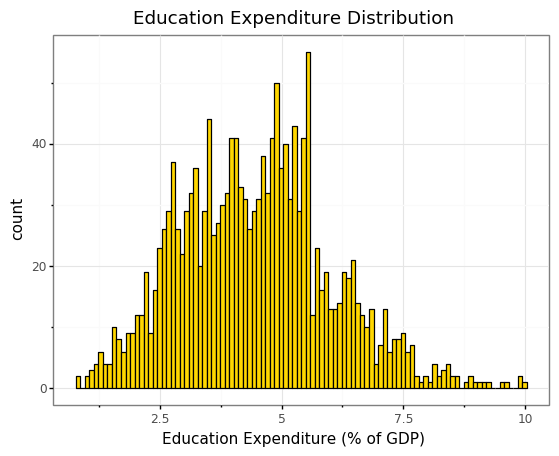

<ggplot: (-9223371940649291204)>

In [333]:
plot1

In [341]:
# viewing the same data differently
plot2 = (ggplot(df_1, aes(x = 'year', y = 'edu_exp')) +
  geom_point(alpha=.5, fill="green")+
 labs(title="Education Expenditure Distribution", x="Year",y="Education Expenditure (% of GDP)")+
 geom_abline(linetype="dashed",color="darkred",size=1) +
theme_bw())

# save plot
#plot2.save("plot2.png", dpi =300)

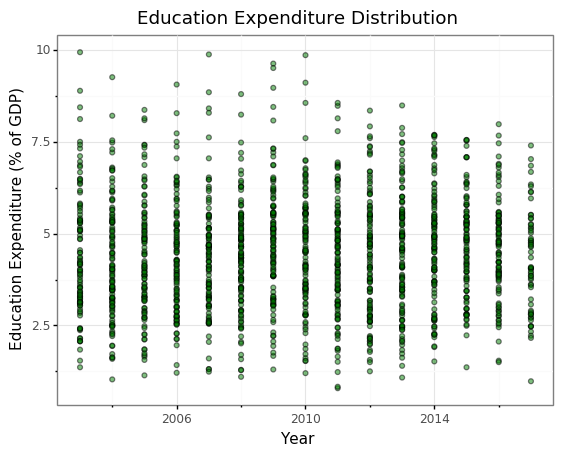

<ggplot: (-9223371940648843720)>

In [342]:
plot2

Since values above 10 on the y-axis seem to be outliers that may bias our results, we will perform data anaylsis on data that excludes these outliers. 

In [83]:
# remove outliers (rows where edu_exp > 10)
df_1 = df_1[df_1.edu_exp <= 10]

In [247]:
# previously 1602
df_1.shape

(1590, 1802)

#### Check data types

In [248]:
df_1.dtypes

country                   object
year                       int64
edu_exp                  float64
v2x_polyarchy            float64
v2x_polyarchy_codelow    float64
                          ...   
v2xca_academ_codehigh    float64
v2xca_academ_sd          float64
AF                         int32
AS                         int32
EU                         int32
Length: 1802, dtype: object

#### Add continent dummy variable to control for some cultural and other factors that relate to educational expenditure.

In [189]:
#get list of country names
country_names = list(df_1['country'])

In [126]:
'burkina-faso' in country_names

True

In [173]:
# remove - from country names
country_names_new = []

for x in country_names:
    if x =='guinea-bissau' and x == 'timor-leste':
        country_names_new.append(x)
    else:
        country_names_new.append(x.replace('-', ' '))

In [190]:
country_names_new = []

for x in country_names:
    country_names_new.append(x.replace('-', ' '))

In [191]:
# replace 'guinea bissau' with 'guinea-bissau'
country_names_new = ["guinea-bissau" if x=="guinea bissau" else x for x in country_names_new]

In [192]:
# replace 'timor leste' with 'timor-leste'
country_names_new = ["timor-leste" if x=="timor leste" else x for x in country_names_new]

In [193]:
'burkina-faso' in country_names_new

False

In [194]:
'timor leste' in country_names_new

False

In [195]:
"cote d'ivoire" in country_names_new

True

In [196]:
len(country_names_new)

1590

In [197]:
# replace cote d'ivoire with côte d'ivoire since py package does not recognize cote d'ivoire
country_names_new = ["côte d'ivoire" if x=="cote d'ivoire" else x for x in country_names_new]

In [198]:
"cote d'ivoire" in country_names_new

False

In [199]:
'dr congo' in country_names_new

True

In [200]:
# replace dr congo with congo
country_names_new = ["congo" if x=="dr congo" else x for x in country_names_new]

In [202]:
continent_list = []

for country in country_names_new:
    if country == 'timor-leste':
        continent_list.append('AS')
    else:
        name = country.lower()
        country_code = pc.country_name_to_country_alpha2(name, cn_name_format="lower")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        continent_list.append(continent_name)

In [203]:
len(continent_list)

1590

In [204]:
len(df_1.country)

1590

In [205]:
set(continent_list)

{'AF', 'AS', 'EU', 'NA', 'OC', 'SA'}

In [345]:
# append continent list to df_1
df_1['continent'] = np.array(continent_list)

In [346]:
set(df_1.continent.isnull())

{False}

View continent variable.

In [349]:
plot3 = (ggplot(df_1, aes(x = 'continent')) +
  geom_histogram(fill="teal", color="black") +
 labs(title="Observations by Continent", x="Continent", y="Count") +
 theme_bw())

# save plot
plot3.save("plot3.png", dpi =300)

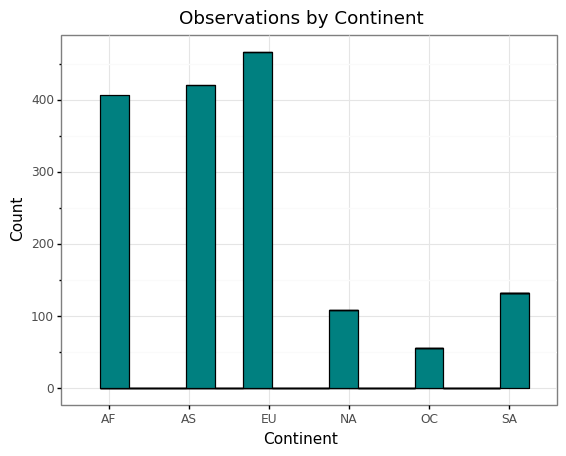

<ggplot: (-9223371940644597308)>

In [350]:
plot3

In [222]:
# Convert into categorical variable, keeping NA, OC and SA as baseline.
df_1['continent'] = pd.Categorical(df_1['continent'])

In [223]:
# check categories
print(df_1['continent'].cat.categories)

Index(['AF', 'AS', 'EU', 'NA', 'OC', 'SA'], dtype='object')


In [224]:
df_1['AF'] = 1*(df_1['continent'] == "AF")
df_1['AS'] = 1*(df_1['continent'] == "AS")
df_1['EU'] = 1*(df_1['continent'] == "EU")

# Everything else ("NA", "OC" and "SA") is the baseline. 

In [225]:
# Drop continent variable
df_1 = df_1.drop(columns=["continent"])

In [226]:
# view dataframe
df_1.head(10)

country  year  edu_exp  v2x_polyarchy  v2x_polyarchy_codelow  \
0  afghanistan  2010     3.48          0.362                  0.330   
1  afghanistan  2011     3.46          0.369                  0.330   
2  afghanistan  2012     2.60          0.371                  0.317   
3  afghanistan  2013     3.45          0.362                  0.317   
4  afghanistan  2014     3.70          0.403                  0.352   
5  afghanistan  2015     3.26          0.396                  0.355   
6  afghanistan  2016     4.23          0.383                  0.340   
7  afghanistan  2017     4.06          0.369                  0.328   
8      albania  2003     3.14          0.535                  0.478   
9      albania  2004     3.23          0.495                  0.433   

   v2x_polyarchy_codehigh  v2x_polyarchy_sd  v2x_libdem  v2x_libdem_codelow  \
0                   0.387             0.029       0.238               0.211   
1                   0.424             0.045       0.241               0.217   
2                   0.416             0.053       0.242               0.204   
3                   0.399             0.058       0.232               0.190   
4                   0.457             0.054       0.262               0.229   
5                   0.456             0.053       0.252               0.220   
6                   0.415             0.037       0.231               0.194   
7                   0.400             0.035       0.229               0.202   
8                   0.578             0.072       0.416               0.369   
9                   0.548             0.055       0.411               0.370   

   v2x_libdem_codehigh  ...  v2xps_party_codehigh  v2x_divparctrl  v2x_feduni  \
0                0.265  ...                 0.382           1.350       0.096   
1                0.262  ...                 0.382           1.350       0.096   
2                0.263  ...                 0.391           1.352       0.096   
3                0.256  ...                 0.349           1.024       0.068   
4                0.284  ...                 0.349           1.024       0.068   
5                0.282  ...                 0.349           1.024       0.068   
6                0.265  ...                 0.369           0.965       0.074   
7                0.269  ...                 0.332           0.678       0.021   
8                0.454  ...                 0.680           1.605       0.474   
9                0.450  ...                 0.680           1.605       0.474   

   v2xca_academ  v2xca_academ_codelow  v2xca_academ_codehigh  v2xca_academ_sd  \
0           NaN                   NaN                    NaN              NaN   
1           NaN                   NaN                    NaN              NaN   
2           NaN                   NaN                    NaN              NaN   
3           NaN                   NaN                    NaN              NaN   
4           NaN                   NaN                    NaN              NaN   
5           NaN                   NaN                    NaN              NaN   
6           NaN                   NaN                    NaN              NaN   
7           NaN                   NaN                    NaN              NaN   
8         0.829                 0.701                  0.894            0.639   
9         0.829                 0.701                  0.894            0.639   

   AF  AS  EU  
0   0   1   0  
1   0   1   0  
2   0   1   0  
3   0   1   0  
4   0   1   0  
5   0   1   0  
6   0   1   0  
7   0   1   0  
8   0   0   1  
9   0   0   1  

[10 rows x 1802 columns]

Set unit of analysis to country-year.

In [399]:
# set unit of analysis country-year
df_1.set_index(['country','year'], inplace=True)

In [227]:
# view df_1
df_1.head()

country  year  edu_exp  v2x_polyarchy  v2x_polyarchy_codelow  \
0  afghanistan  2010     3.48          0.362                  0.330   
1  afghanistan  2011     3.46          0.369                  0.330   
2  afghanistan  2012     2.60          0.371                  0.317   
3  afghanistan  2013     3.45          0.362                  0.317   
4  afghanistan  2014     3.70          0.403                  0.352   

   v2x_polyarchy_codehigh  v2x_polyarchy_sd  v2x_libdem  v2x_libdem_codelow  \
0                   0.387             0.029       0.238               0.211   
1                   0.424             0.045       0.241               0.217   
2                   0.416             0.053       0.242               0.204   
3                   0.399             0.058       0.232               0.190   
4                   0.457             0.054       0.262               0.229   

   v2x_libdem_codehigh  ...  v2xps_party_codehigh  v2x_divparctrl  v2x_feduni  \
0                0.265  ...                 0.382           1.350       0.096   
1                0.262  ...                 0.382           1.350       0.096   
2                0.263  ...                 0.391           1.352       0.096   
3                0.256  ...                 0.349           1.024       0.068   
4                0.284  ...                 0.349           1.024       0.068   

   v2xca_academ  v2xca_academ_codelow  v2xca_academ_codehigh  v2xca_academ_sd  \
0           NaN                   NaN                    NaN              NaN   
1           NaN                   NaN                    NaN              NaN   
2           NaN                   NaN                    NaN              NaN   
3           NaN                   NaN                    NaN              NaN   
4           NaN                   NaN                    NaN              NaN   

   AF  AS  EU  
0   0   1   0  
1   0   1   0  
2   0   1   0  
3   0   1   0  
4   0   1   0  

[5 rows x 1802 columns]

Testing hierarchical indexing.

In [212]:
tester = df_1.copy()

In [213]:
tester.set_index(['continent','country','year'], inplace = True)

In [215]:
tester.head()

edu_exp  v2x_polyarchy  v2x_polyarchy_codelow  \
continent country     year                                                  
AS        afghanistan 2010     3.48          0.362                  0.330   
                      2011     3.46          0.369                  0.330   
                      2012     2.60          0.371                  0.317   
                      2013     3.45          0.362                  0.317   
                      2014     3.70          0.403                  0.352   

                            v2x_polyarchy_codehigh  v2x_polyarchy_sd  \
continent country     year                                             
AS        afghanistan 2010                   0.387             0.029   
                      2011                   0.424             0.045   
                      2012                   0.416             0.053   
                      2013                   0.399             0.058   
                      2014                   0.457             0.054   

                            v2x_libdem  v2x_libdem_codelow  \
continent country     year                                   
AS        afghanistan 2010       0.238               0.211   
                      2011       0.241               0.217   
                      2012       0.242               0.204   
                      2013       0.232               0.190   
                      2014       0.262               0.229   

                            v2x_libdem_codehigh  v2x_libdem_sd  v2x_partipdem  \
continent country     year                                                      
AS        afghanistan 2010                0.265          0.027          0.156   
                      2011                0.262          0.022          0.158   
                      2012                0.263          0.029          0.160   
                      2013                0.256          0.040          0.152   
                      2014                0.284          0.028          0.164   

                            ...  v2xme_altinf_sd  v2xps_party  \
continent country     year  ...                                 
AS        afghanistan 2010  ...            0.641        0.270   
                      2011  ...            0.641        0.270   
                      2012  ...            0.641        0.273   
                      2013  ...            0.642        0.207   
                      2014  ...            0.616        0.207   

                            v2xps_party_codelow  v2xps_party_codehigh  \
continent country     year                                              
AS        afghanistan 2010                0.167                 0.382   
                      2011                0.167                 0.382   
                      2012                0.170                 0.391   
                      2013                0.118                 0.349   
                      2014                0.118                 0.349   

                            v2x_divparctrl  v2x_feduni  v2xca_academ  \
continent country     year                                             
AS        afghanistan 2010           1.350       0.096           NaN   
                      2011           1.350       0.096           NaN   
                      2012           1.352       0.096           NaN   
                      2013           1.024       0.068           NaN   
                      2014           1.024       0.068           NaN   

                            v2xca_academ_codelow  v2xca_academ_codehigh  \
continent country     year                                                
AS        afghanistan 2010                   NaN                    NaN   
                      2011                   NaN                    NaN   
                      2012                   NaN                    NaN   
                      2013                   NaN                    NaN   
                      2014                   NaN         

# <center> Analysis Part 1: Using High-Level and Low-Level Indices

## High-Level and Low-Level Indices

In [235]:
# create copy and set index
df_hl = df_1.copy()
df_hl.set_index(['country','year'], inplace = True)

In [236]:
df_hl.head()

edu_exp  v2x_polyarchy  v2x_polyarchy_codelow  \
country     year                                                  
afghanistan 2010     3.48          0.362                  0.330   
            2011     3.46          0.369                  0.330   
            2012     2.60          0.371                  0.317   
            2013     3.45          0.362                  0.317   
            2014     3.70          0.403                  0.352   

                  v2x_polyarchy_codehigh  v2x_polyarchy_sd  v2x_libdem  \
country     year                                                         
afghanistan 2010                   0.387             0.029       0.238   
            2011                   0.424             0.045       0.241   
            2012                   0.416             0.053       0.242   
            2013                   0.399             0.058       0.232   
            2014                   0.457             0.054       0.262   

                  v2x_libdem_codelow  v2x_libdem_codehigh  v2x_libdem_sd  \
country     year                                                           
afghanistan 2010               0.211                0.265          0.027   
            2011               0.217                0.262          0.022   
            2012               0.204                0.263          0.029   
            2013               0.190                0.256          0.040   
            2014               0.229                0.284          0.028   

                  v2x_partipdem  ...  v2xps_party_codehigh  v2x_divparctrl  \
country     year                 ...                                         
afghanistan 2010          0.156  ...                 0.382           1.350   
            2011          0.158  ...                 0.382           1.350   
            2012          0.160  ...                 0.391           1.352   
            2013          0.152  ...                 0.349           1.024   
            2014          0.164  ...                 0.349           1.024   

                  v2x_feduni  v2xca_academ  v2xca_academ_codelow  \
country     year                                                   
afghanistan 2010       0.096           NaN                   NaN   
            2011       0.096           NaN                   NaN   
            2012       0.096           NaN                   NaN   
            2013       0.068           NaN                   NaN   
            2014       0.068           NaN                   NaN   

                  v2xca_academ_codehigh  v2xca_academ_sd  AF  AS  EU  
country     year                                                      
afghanistan 2010                    NaN              NaN   0   1   0  
            2011                    NaN              NaN   0   1   0  
            2012                    NaN              NaN   0   1   0  
            2013                    NaN              NaN   0   1   0  
            2014                    NaN              NaN   0   1   0  

[5 rows x 1800 columns]

In [237]:
# select only the columns with high and low-level indices
df_hl = df_hl[['edu_exp','AF','AS','EU','v2x_polyarchy','v2x_libdem','v2x_partipdem','v2x_delibdem',
                'v2x_egaldem','v2x_api','v2x_mpi','v2x_freexp_altinf','v2x_frassoc_thick','v2x_suffr','v2xel_frefair',
                'v2x_elecoff','v2x_liberal','v2xcl_rol','v2x_jucon','v2xlg_legcon','v2x_partip','v2x_cspart','v2xdd_dd',
                'v2xel_locelec','v2xel_regelec','v2xdl_delib','v2x_egal','v2xeg_eqprotec','v2xeg_eqaccess','v2xeg_eqdr']]

In [238]:
# view data
df_hl.head()

edu_exp  AF  AS  EU  v2x_polyarchy  v2x_libdem  \
country     year                                                   
afghanistan 2010     3.48   0   1   0          0.362       0.238   
            2011     3.46   0   1   0          0.369       0.241   
            2012     2.60   0   1   0          0.371       0.242   
            2013     3.45   0   1   0          0.362       0.232   
            2014     3.70   0   1   0          0.403       0.262   

                  v2x_partipdem  v2x_delibdem  v2x_egaldem  v2x_api  ...  \
country     year                                                     ...   
afghanistan 2010          0.156         0.319        0.215    0.643  ...   
            2011          0.158         0.314        0.223    0.653  ...   
            2012          0.160         0.352        0.228    0.643  ...   
            2013          0.152         0.313        0.225    0.637  ...   
            2014          0.164         0.354        0.239    0.666  ...   

                  v2x_partip  v2x_cspart  v2xdd_dd  v2xel_locelec  \
country     year                                                    
afghanistan 2010       0.297       0.656      0.02          0.007   
            2011       0.297       0.656      0.02          0.007   
            2012       0.297       0.656      0.02          0.007   
            2013       0.285       0.680      0.02          0.106   
            2014       0.285       0.680      0.02          0.106   

                  v2xel_regelec  v2xdl_delib  v2x_egal  v2xeg_eqprotec  \
country     year                                                         
afghanistan 2010          0.190        0.776     0.467           0.537   
            2011          0.190        0.760     0.467           0.537   
            2012          0.190        0.807     0.467           0.537   
            2013          0.134        0.754     0.504           0.536   
            2014          0.134        0.753     0.483           0.498   

                  v2xeg_eqaccess  v2xeg_eqdr  
country     year                              
afghanistan 2010           0.547       0.405  
            2011           0.547       0.405  
            2012           0.547       0.405  
            2013           0.575       0.344  
            2014           0.575       0.323  

[5 rows x 30 columns]

In [239]:
# view shape
df_hl.shape

(1590, 30)

### Improve Readability

#### Rename variables for ease of readability based on tables above. 

In [240]:
# re-name high-level indices (_hl is to indicate that it is a high-level index)
df_hl.rename(columns={'v2x_polyarchy': 'polyarchy_hl'}, inplace=True)
df_hl.rename(columns={'v2x_libdem': 'libdem_hl'}, inplace=True)
df_hl.rename(columns={'v2x_partipdem': 'partipdem_hl'}, inplace=True)
df_hl.rename(columns={'v2x_delibdem': 'delibdem_hl'}, inplace=True)
df_hl.rename(columns={'v2x_egaldem': 'egaldem_hl'}, inplace=True)

In [241]:
df_hl.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  v2x_api  ...  v2x_partip  \
country     year                                    ...               
afghanistan 2010        0.319       0.215    0.643  ...       0.297   
            2011        0.314       0.223    0.653  ...       0.297   
            2012        0.352       0.228    0.643  ...       0.297   
            2013        0.313       0.225    0.637  ...       0.285   
            2014        0.354       0.239    0.666  ...       0.285   

                  v2x_cspart  v2xdd_dd  v2xel_locelec  v2xel_regelec  \
country     year                                                       
afghanistan 2010       0.656      0.02          0.007          0.190   
            2011       0.656      0.02          0.007          0.190   
            2012       0.656      0.02          0.007          0.190   
            2013       0.680      0.02          0.106          0.134   
            2014       0.680      0.02          0.106          0.134   

                  v2xdl_delib  v2x_egal  v2xeg_eqprotec  v2xeg_eqaccess  \
country     year                                                          
afghanistan 2010        0.776     0.467           0.537           0.547   
            2011        0.760     0.467           0.537           0.547   
            2012        0.807     0.467           0.537           0.547   
            2013        0.754     0.504           0.536           0.575   
            2014        0.753     0.483           0.498           0.575   

                  v2xeg_eqdr  
country     year              
afghanistan 2010       0.405  
            2011       0.405  
            2012       0.405  
            2013       0.344  
            2014       0.323  

[5 rows x 30 columns]

In [242]:
## re-name low-level indices

# Electoral Democracy Index (EDI)
df_hl.rename(columns={'v2x_freexp_altinf': 'freexp_altinf_EDI'}, inplace=True)
df_hl.rename(columns={'v2x_frassoc_thick': 'frassoc_thick_EDI'}, inplace=True)
df_hl.rename(columns={'v2x_suffr': 'suffr_EDI'}, inplace=True)
df_hl.rename(columns={'v2xel_frefair': 'el_frefair_EDI'}, inplace=True)
df_hl.rename(columns={'v2x_elecof': 'elecof_EDI'}, inplace=True)

# Liberal Democracy Index (LDI)
df_hl.rename(columns={'v2xcl_rol': 'cl_rol_LDI'}, inplace=True)
df_hl.rename(columns={'v2x_jucon': 'jucon_LDI'}, inplace=True)
df_hl.rename(columns={'v2xlg_legcon': 'lg_legcon_LDI'}, inplace=True)

# Participatory Democracy Index (PDI)
df_hl.rename(columns={'v2x_cspart': 'cspart_PDI'}, inplace=True)
df_hl.rename(columns={'v2xdd_dd': 'dd_dd_PDI'}, inplace=True)
df_hl.rename(columns={'v2xel_locelec': 'el_locelec_PDI'}, inplace=True)
df_hl.rename(columns={'v2xel_regelec': 'el_regelec_PDI'}, inplace=True)

# Egalitarian Democracy Index (EgDI)
df_hl.rename(columns={'v2xeg_eqprotec': 'eg_eqprotec_EgDI'}, inplace=True)
df_hl.rename(columns={'v2xeg_eqaccess': 'eg_eqaccess_EgDI'}, inplace=True) 
df_hl.rename(columns={'v2xeg_eqdr': 'eg_eqdr_EgDI'}, inplace=True)

In [243]:
# now the only variables without _ are the mid-level indices. Remove v2x from them and add _ml (for mid-level)
df_hl.rename(columns={'v2x_api': 'api_ml'}, inplace=True)
df_hl.rename(columns={'v2x_mpi': 'mpi_ml'}, inplace=True)
df_hl.rename(columns={'v2x_elecoff': 'elecoff_ml'}, inplace=True)
df_hl.rename(columns={'v2x_liberal': 'liberal_ml'}, inplace=True)
df_hl.rename(columns={'v2xdl_delib': 'dl_delib_ml'}, inplace=True)
df_hl.rename(columns={'v2x_egal': 'egal_ml'}, inplace=True)
df_hl.rename(columns={'v2x_partip': 'partip_ml'}, inplace=True)

In [246]:
# view dataframe
df_hl.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  api_ml  ...  partip_ml  cspart_PDI  \
country     year                                   ...                          
afghanistan 2010        0.319       0.215   0.643  ...      0.297       0.656   
            2011        0.314       0.223   0.653  ...      0.297       0.656   
            2012        0.352       0.228   0.643  ...      0.297       0.656   
            2013        0.313       0.225   0.637  ...      0.285       0.680   
            2014        0.354       0.239   0.666  ...      0.285       0.680   

                  dd_dd_PDI  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  \
country     year                                                           
afghanistan 2010       0.02           0.007           0.190        0.776   
            2011       0.02           0.007           0.190        0.760   
            2012       0.02           0.007           0.190        0.807   
            2013       0.02           0.106           0.134        0.754   
            2014       0.02           0.106           0.134        0.753   

                  egal_ml  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  
country     year                                                             
afghanistan 2010    0.467             0.537             0.547         0.405  
            2011    0.467             0.537             0.547         0.405  
            2012    0.467             0.537             0.547         0.405  
            2013    0.504             0.536             0.575         0.344  
            2014    0.483             0.498             0.575         0.323  

[5 rows x 30 columns]

### Examine Data

In [249]:
# check shape
df_hl.shape

(1590, 30)

In [250]:
# check data types
df_hl.dtypes

edu_exp              float64
AF                     int32
AS                     int32
EU                     int32
polyarchy_hl         float64
libdem_hl            float64
partipdem_hl         float64
delibdem_hl          float64
egaldem_hl           float64
api_ml               float64
mpi_ml               float64
freexp_altinf_EDI    float64
frassoc_thick_EDI    float64
suffr_EDI            float64
el_frefair_EDI       float64
elecoff_ml           float64
liberal_ml           float64
cl_rol_LDI           float64
jucon_LDI            float64
lg_legcon_LDI        float64
partip_ml            float64
cspart_PDI           float64
dd_dd_PDI            float64
el_locelec_PDI       float64
el_regelec_PDI       float64
dl_delib_ml          float64
egal_ml              float64
eg_eqprotec_EgDI     float64
eg_eqaccess_EgDI     float64
eg_eqdr_EgDI         float64
dtype: object

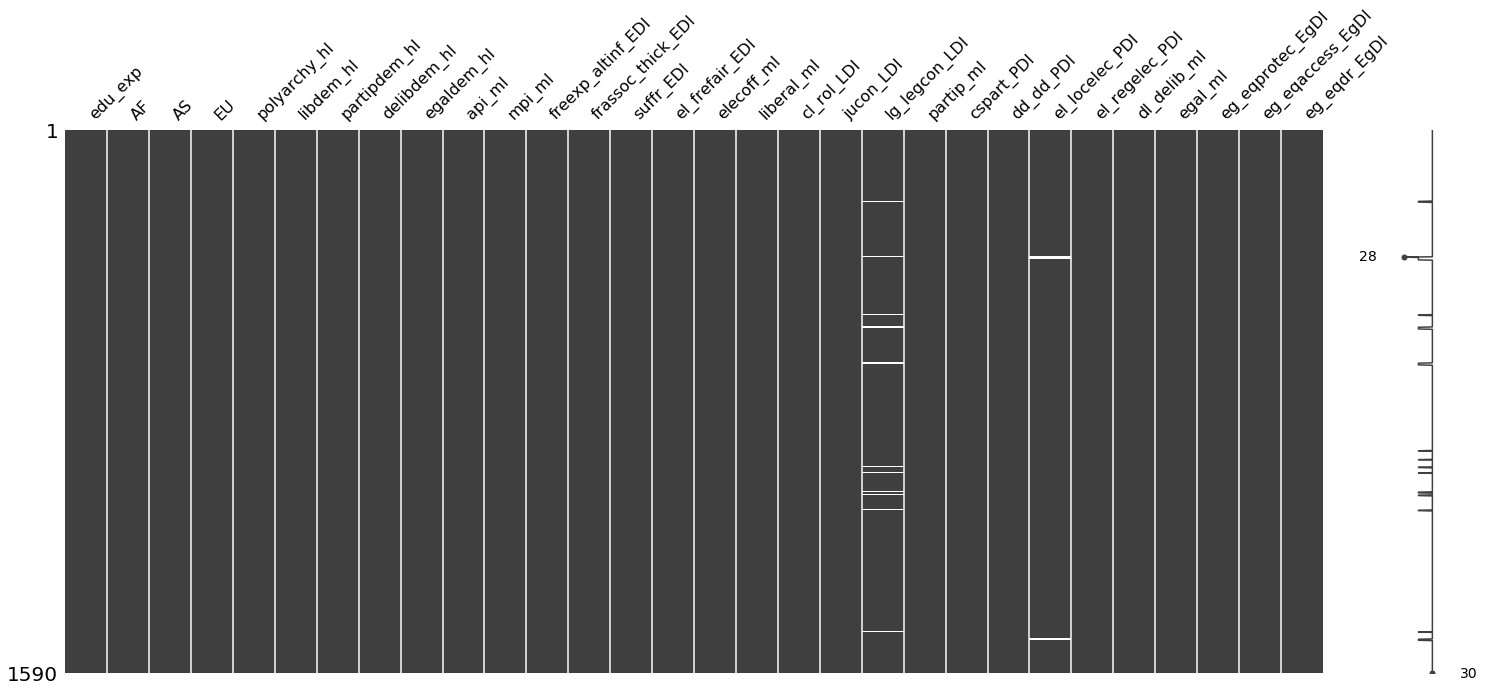

In [251]:
# check for missing data
miss.matrix(df_hl)

Some data for lg_legcon_LDI and el_locelec_PDI is missing. Both are low-level indeces, the former is measuring to what extent are the legislature and government agencies e.g., comptroller general, general prosecutor, or ombudsman capable of questioning, investigating, and exercising oversight over the executive? And the latter is measuring whether there are elected local governments, and — if so — to what extent can they operate without interference from unelected bodies at the local level?

In [253]:
# fill missing values with mean column values
df_hl.fillna(df_hl.mean(), inplace=True)

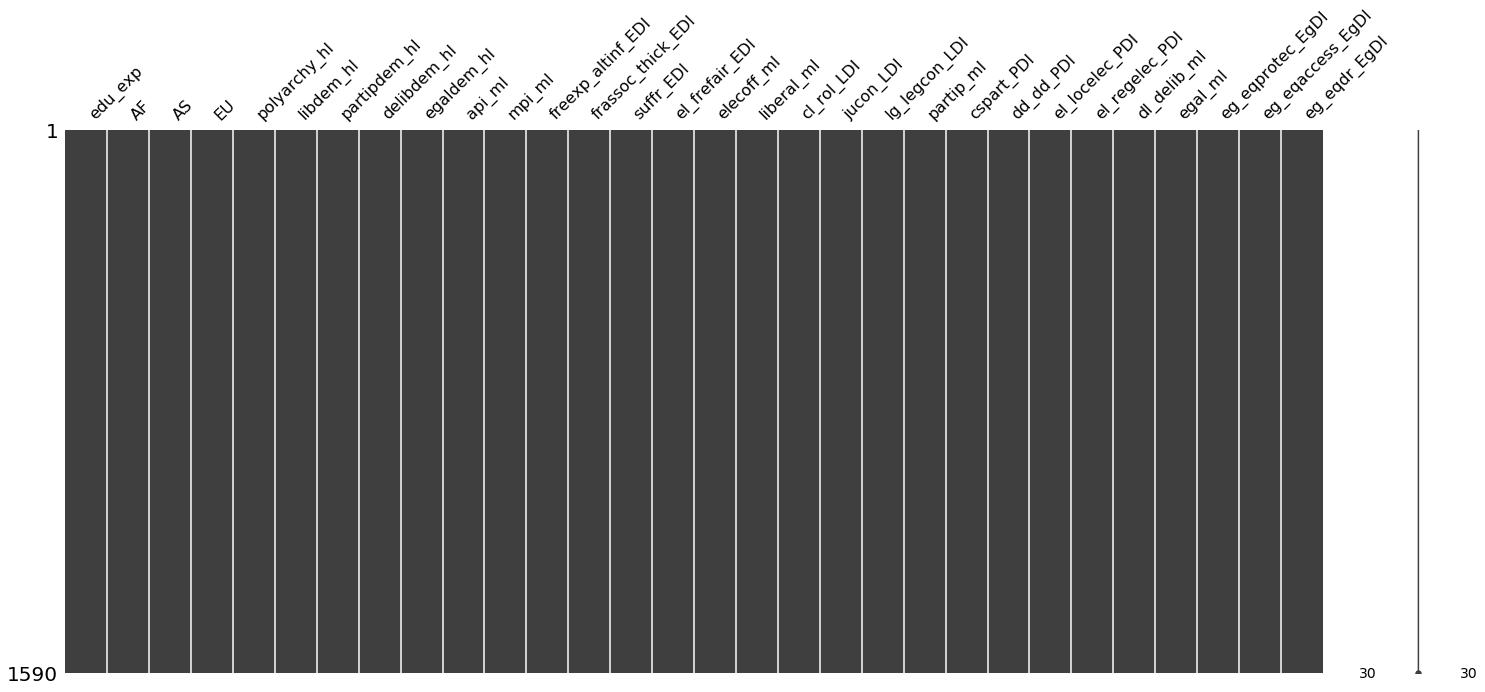

In [254]:
# check for missingness again
miss.matrix(df_hl)

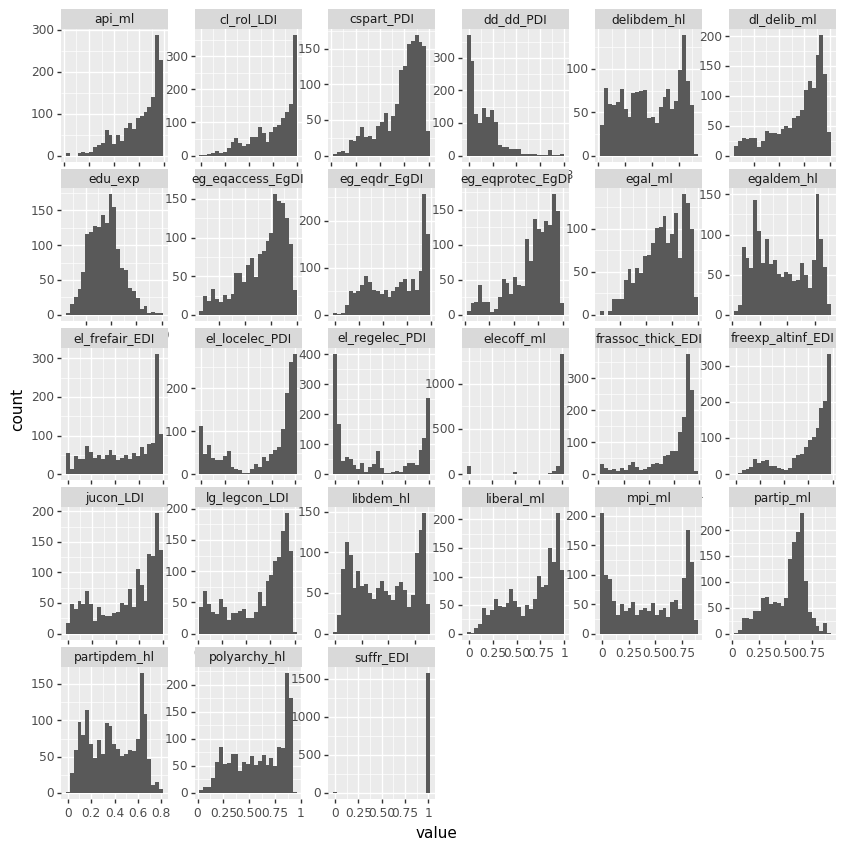

<ggplot: (-9223371940747633364)>

In [256]:
# Plot the continuous variables 
d = df_hl.select_dtypes(include=["float64"]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,10),
          subplots_adjust={'wspace':0.25})
)

elecoff_ml (elected officials index) has almost all observations at 1 with only a few at zero, and even fewer at 0.5. This variable captures whether the chief executive and legislature are appointed through popular election, and the way it is calculated (given in the codebook) means that we can either get a value of 0, 0.5 or 1.

suffr_EDI (share of population with suffrage) is coded as 100% if there is universal suffrage and 50% if there only universal male suffrage. From the graph we can see that every country has universal suffrage. 

## <center> <font color="green"> Exploratory Machine Learning Model </font>
Outcome: difference in education expenditure
<br>
Predictors: High-Level Democracy Indices

In [261]:
# create copy of df_hl
df_ml1 = df_hl.copy()

In [262]:
df_ml1.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  api_ml  ...  partip_ml  cspart_PDI  \
country     year                                   ...                          
afghanistan 2010        0.319       0.215   0.643  ...      0.297       0.656   
            2011        0.314       0.223   0.653  ...      0.297       0.656   
            2012        0.352       0.228   0.643  ...      0.297       0.656   
            2013        0.313       0.225   0.637  ...      0.285       0.680   
            2014        0.354       0.239   0.666  ...      0.285       0.680   

                  dd_dd_PDI  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  \
country     year                                                           
afghanistan 2010       0.02           0.007           0.190        0.776   
            2011       0.02           0.007           0.190        0.760   
            2012       0.02           0.007           0.190        0.807   
            2013       0.02           0.106           0.134        0.754   
            2014       0.02           0.106           0.134        0.753   

                  egal_ml  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  
country     year                                                             
afghanistan 2010    0.467             0.537             0.547         0.405  
            2011    0.467             0.537             0.547         0.405  
            2012    0.467             0.537             0.547         0.405  
            2013    0.504             0.536             0.575         0.344  
            2014    0.483             0.498             0.575         0.323  

[5 rows x 30 columns]

In [263]:
# create new column that calculates the difference between edu_exp by country-year.
df_ml1['edu_exp_diff'] = np.nan 

for idx in df_ml1.index.levels[0]:
    df_ml1.edu_exp_diff[idx] = df_ml1.edu_exp[idx].diff()

In [264]:
df_ml1.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  api_ml  ...  cspart_PDI  dd_dd_PDI  \
country     year                                   ...                          
afghanistan 2010        0.319       0.215   0.643  ...       0.656       0.02   
            2011        0.314       0.223   0.653  ...       0.656       0.02   
            2012        0.352       0.228   0.643  ...       0.656       0.02   
            2013        0.313       0.225   0.637  ...       0.680       0.02   
            2014        0.354       0.239   0.666  ...       0.680       0.02   

                  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  egal_ml  \
country     year                                                         
afghanistan 2010           0.007           0.190        0.776    0.467   
            2011           0.007           0.190        0.760    0.467   
            2012           0.007           0.190        0.807    0.467   
            2013           0.106           0.134        0.754    0.504   
            2014           0.106           0.134        0.753    0.483   

                  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  \
country     year                                                     
afghanistan 2010             0.537             0.547         0.405   
            2011             0.537             0.547         0.405   
            2012             0.537             0.547         0.405   
            2013             0.536             0.575         0.344   
            2014             0.498             0.575         0.323   

                  edu_exp_diff  
country     year                
afghanistan 2010           NaN  
            2011         -0.02  
            2012         -0.86  
            2013          0.85  
            2014          0.25  

[5 rows x 31 columns]

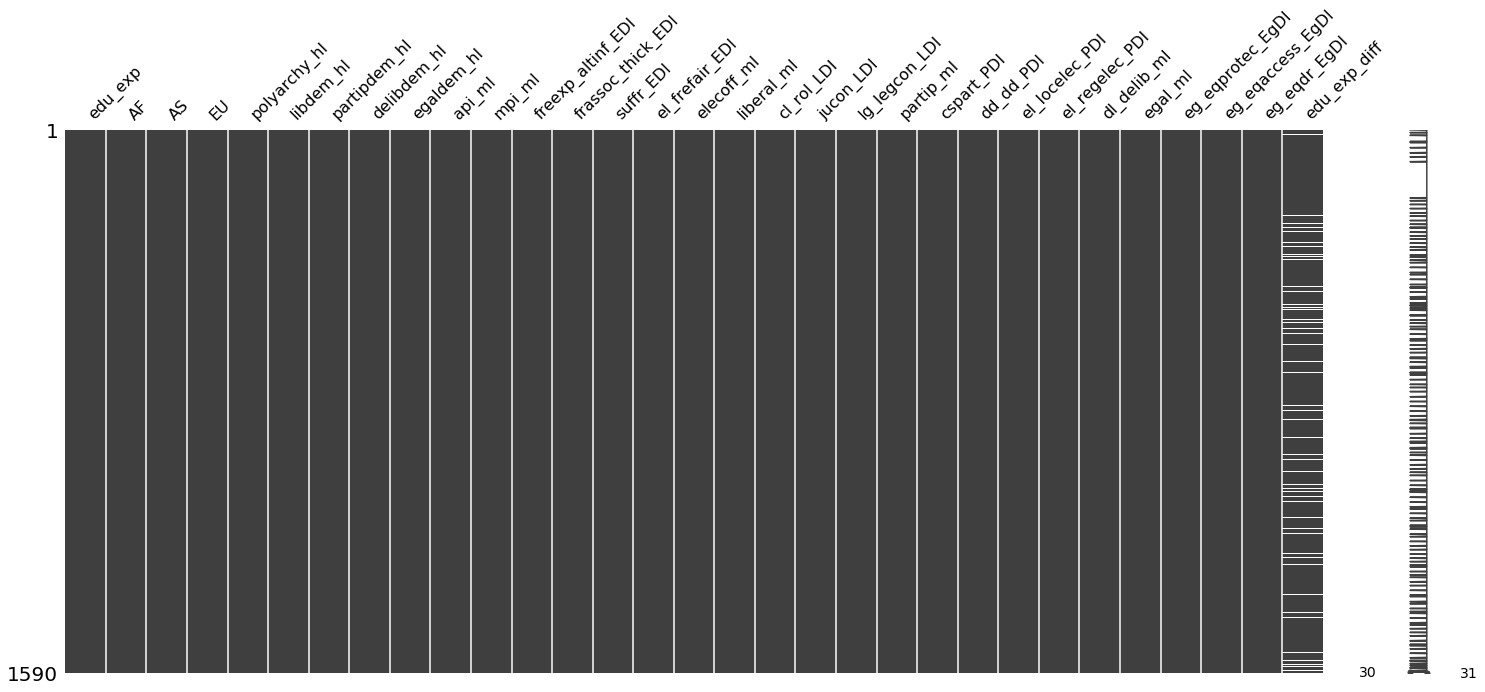

In [266]:
# check for missingness
miss.matrix(df_ml1)

The missing data is the value of edu_exp_diff in the first year of every country. Since there's no previous year to compare that value with, it is coded as nan. Let's replace all the missing values with 0.  

In [267]:
df_ml1['edu_exp_diff'] = df_ml1['edu_exp_diff'].replace(np.nan, 0)

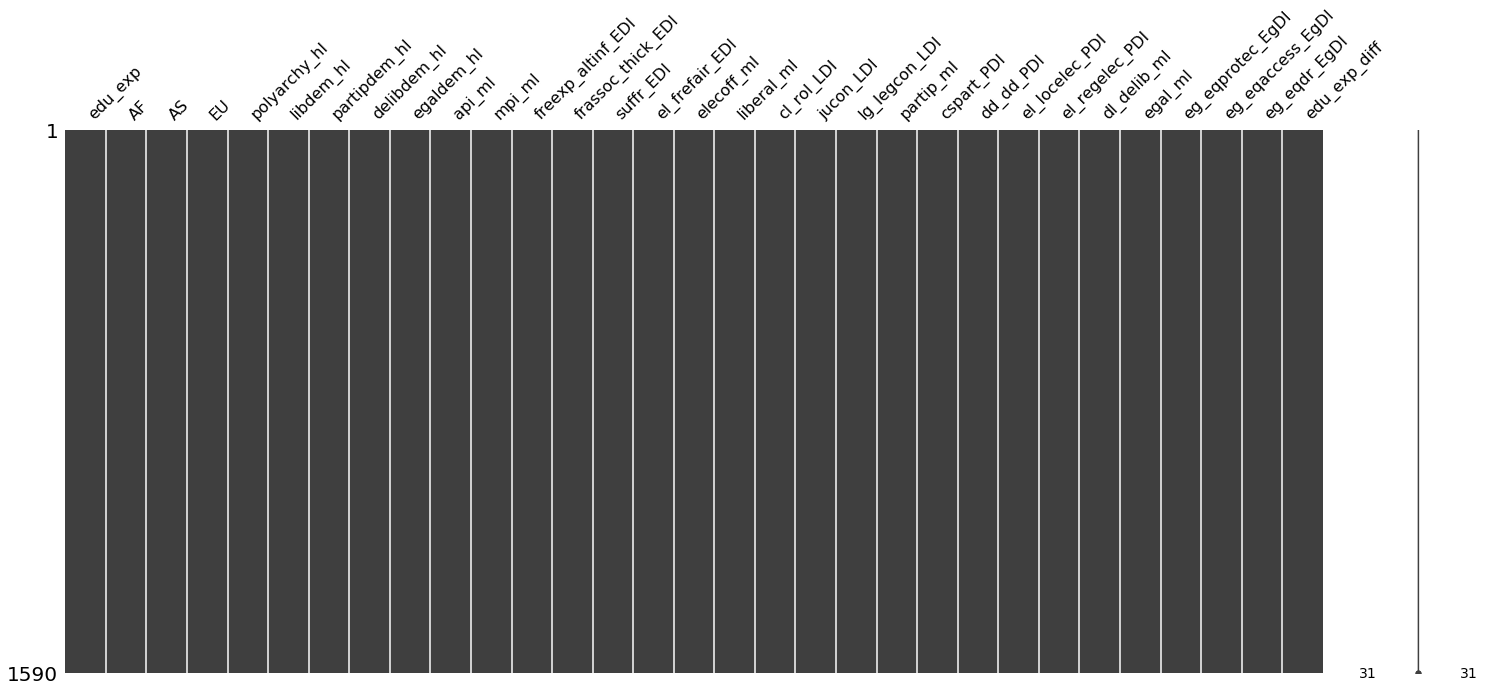

In [268]:
# check for missingness again
miss.matrix(df_ml1)

### Split Data

#### Pick only the High-Level indices as predictors.

In [269]:
y = df_ml1[['edu_exp_diff']]
X = df_ml1[['polyarchy_hl','libdem_hl','partipdem_hl','delibdem_hl','egaldem_hl','AF','AS','EU']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [270]:
print(train_X.shape[0]/df_ml1.shape[0])
print(test_X.shape[0]/df_ml1.shape[0])

0.7496855345911949
0.25031446540880503


In [271]:
# view training data
train_X.head()

polyarchy_hl  libdem_hl  partipdem_hl  delibdem_hl  \
country     year                                                       
austria     2014         0.874      0.790         0.658        0.787   
india       2004         0.767      0.605         0.507        0.701   
vietnam     2012         0.231      0.119         0.200        0.172   
syria       2006         0.153      0.050         0.049        0.034   
switzerland 2006         0.880      0.838         0.777        0.836   

                  egaldem_hl  AF  AS  EU  
country     year                          
austria     2014       0.766   0   0   1  
india       2004       0.514   0   1   0  
vietnam     2012       0.226   0   1   0  
syria       2006       0.094   0   1   0  
switzerland 2006       0.815   0   0   1

### Explore the training data 

In [272]:
# Look at the training data
train_X.shape 

(1192, 8)

In [273]:
train_y.min()

edu_exp_diff   -3.92
dtype: float64

In [274]:
train_y.max()

edu_exp_diff    4.53
dtype: float64

How is the data distributed?

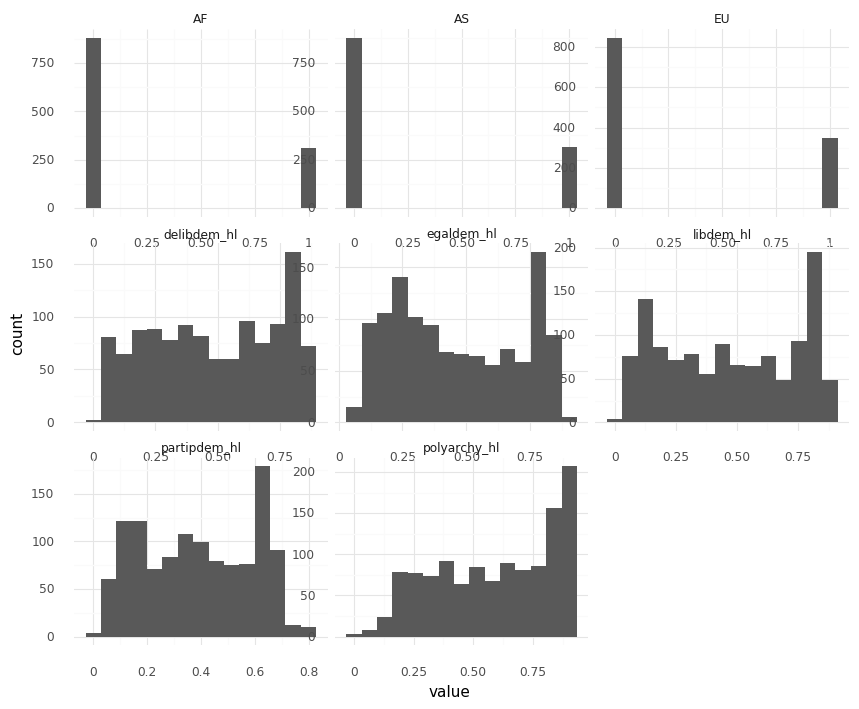

<ggplot: (-9223371940652529588)>

In [275]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All high-level indices are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp_diff` and see if there are any red flags. 

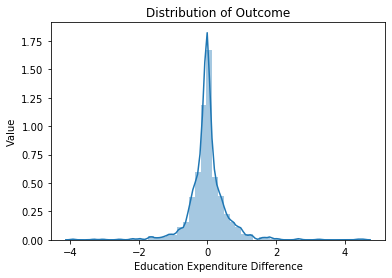

In [276]:
# Seaborn
ax = sns.distplot(train_y.edu_exp_diff,hist=True,kde=True)
ax.set(xlabel="Education Expenditure Difference", ylabel = "Value")
ax.set_title("Distribution of Outcome")

#ax.figure.savefig("edu_exp_diff.png")

Let's just look at how our predictors relate to the outcome.

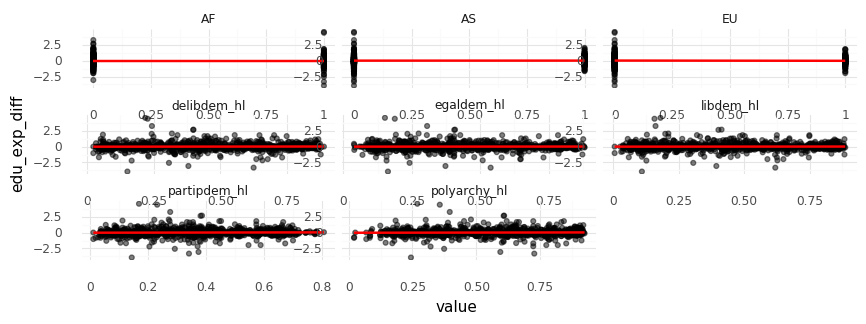

<ggplot: (-9223371940651346292)>

In [277]:
D = train_X.copy()
D['edu_exp_diff'] = train_y

(
    ggplot(D.melt(id_vars=["edu_exp_diff"]),
           aes(x="value",y="edu_exp_diff"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

All our predictors seem to have close to no relationship with the outcome. Let's see if any of these indeces matter the most for a change in education spending. 

## Train Models

### Cross Validation 

In [278]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [279]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [280]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]},
    
    # Linear Model
    {'model' : [LM()]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]}
    
]

## Run Models

Put it all together in a GridSearch

In [281]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

And Run

In [282]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestRegressor(max_depth=2,
                                                          n_estimators=1000)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]},
                         {'model': [LinearRegression()]},
                         {'model': [BaggingRegressor()]}],
             scoring='neg_mean_squared_error')

Lowest MSE:

In [283]:
search.best_score_

-0.3078753639600993

In [284]:
search.best_params_

{'model': RandomForestRegressor(max_depth=2, n_estimators=1000),
 'model__max_depth': 2,
 'model__n_estimators': 1000}

Best model: Random Forest. Trees with a depth of 2, and we spanned across 1000 trees.

In [285]:
rf_mod = search.best_estimator_
rf_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestRegressor(max_depth=2, n_estimators=1000))])

### Test Performance

Check how well the best performing model does on the test data that it wasn't trained on. 


In [286]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [287]:
m.mean_squared_error(test_y,pred_y)

0.2672341842746679

In [288]:
m.r2_score(test_y,pred_y)

-0.0075155408017626435

A negative R-squared means that our prediction is less accurate than the average value of the data set over time. 

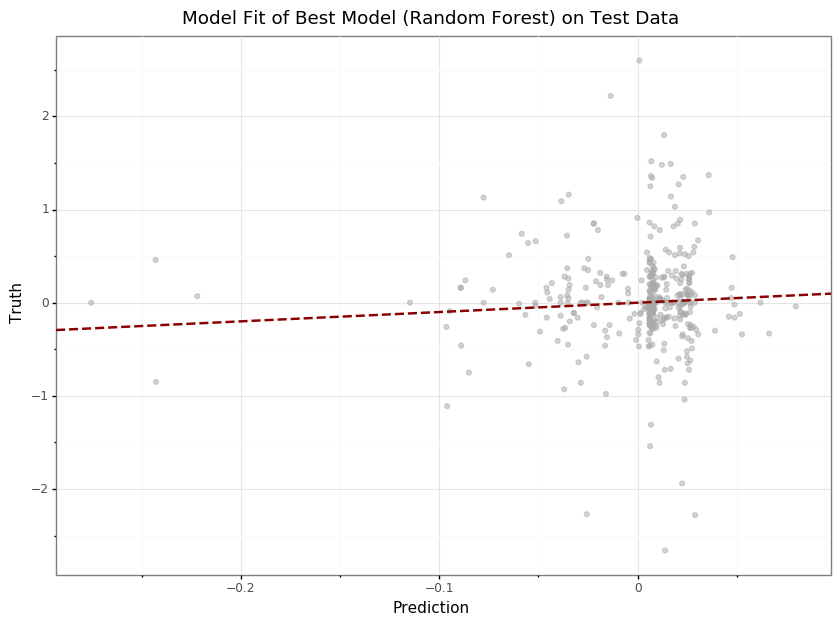

<ggplot: (-9223371940650435932)>

In [289]:
# convert test_y values to 1-dimensional array to use as input for the graph below
array_1 = test_y.values
array_test_y = array_1.flatten() 
array_test_y.shape

# plot
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=array_test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.5, color="darkgray") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(x="Prediction",y="Truth",title="Model Fit of Best Model (Random Forest) on Test Data")+
    theme(figure_size=(10,7))
)

## <center> <font color='green'>First Machine Learning Model </font>

Outcome: Increase in education expenditure
<br>
Predictors: High-Level Indices

In [290]:
# create a copy of df_hl
df_ml2 = df_hl.copy()

In [291]:
df_ml2.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  api_ml  ...  partip_ml  cspart_PDI  \
country     year                                   ...                          
afghanistan 2010        0.319       0.215   0.643  ...      0.297       0.656   
            2011        0.314       0.223   0.653  ...      0.297       0.656   
            2012        0.352       0.228   0.643  ...      0.297       0.656   
            2013        0.313       0.225   0.637  ...      0.285       0.680   
            2014        0.354       0.239   0.666  ...      0.285       0.680   

                  dd_dd_PDI  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  \
country     year                                                           
afghanistan 2010       0.02           0.007           0.190        0.776   
            2011       0.02           0.007           0.190        0.760   
            2012       0.02           0.007           0.190        0.807   
            2013       0.02           0.106           0.134        0.754   
            2014       0.02           0.106           0.134        0.753   

                  egal_ml  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  
country     year                                                             
afghanistan 2010    0.467             0.537             0.547         0.405  
            2011    0.467             0.537             0.547         0.405  
            2012    0.467             0.537             0.547         0.405  
            2013    0.504             0.536             0.575         0.344  
            2014    0.483             0.498             0.575         0.323  

[5 rows x 30 columns]

In [292]:
# create new column that calculates the difference between edu_exp by country-year.

df_ml2['edu_exp_diff'] = np.nan 

for idx in df_ml2.index.levels[0]:
    df_ml2.edu_exp_diff[idx] = df_ml2.edu_exp[idx].diff()

In [293]:
# replace missing values with 0
df_ml2['edu_exp_diff'] = df_ml2['edu_exp_diff'].replace(np.nan, 0)

# set increase (positive number) to 1, decrease/no change to 0
df_ml2['edu_exp_diff'][df_ml2['edu_exp_diff'] <= 0] = 0
df_ml2['edu_exp_diff'][df_ml2['edu_exp_diff'] > 0] = 1

In [294]:
# rename column
df_ml2.rename(columns={'edu_exp_diff': 'edu_exp_increase'}, inplace=True)

In [295]:
df_ml2.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  api_ml  ...  cspart_PDI  dd_dd_PDI  \
country     year                                   ...                          
afghanistan 2010        0.319       0.215   0.643  ...       0.656       0.02   
            2011        0.314       0.223   0.653  ...       0.656       0.02   
            2012        0.352       0.228   0.643  ...       0.656       0.02   
            2013        0.313       0.225   0.637  ...       0.680       0.02   
            2014        0.354       0.239   0.666  ...       0.680       0.02   

                  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  egal_ml  \
country     year                                                         
afghanistan 2010           0.007           0.190        0.776    0.467   
            2011           0.007           0.190        0.760    0.467   
            2012           0.007           0.190        0.807    0.467   
            2013           0.106           0.134        0.754    0.504   
            2014           0.106           0.134        0.753    0.483   

                  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  \
country     year                                                     
afghanistan 2010             0.537             0.547         0.405   
            2011             0.537             0.547         0.405   
            2012             0.537             0.547         0.405   
            2013             0.536             0.575         0.344   
            2014             0.498             0.575         0.323   

                  edu_exp_increase  
country     year                    
afghanistan 2010               0.0  
            2011               0.0  
            2012               0.0  
            2013               1.0  
            2014               1.0  

[5 rows x 31 columns]

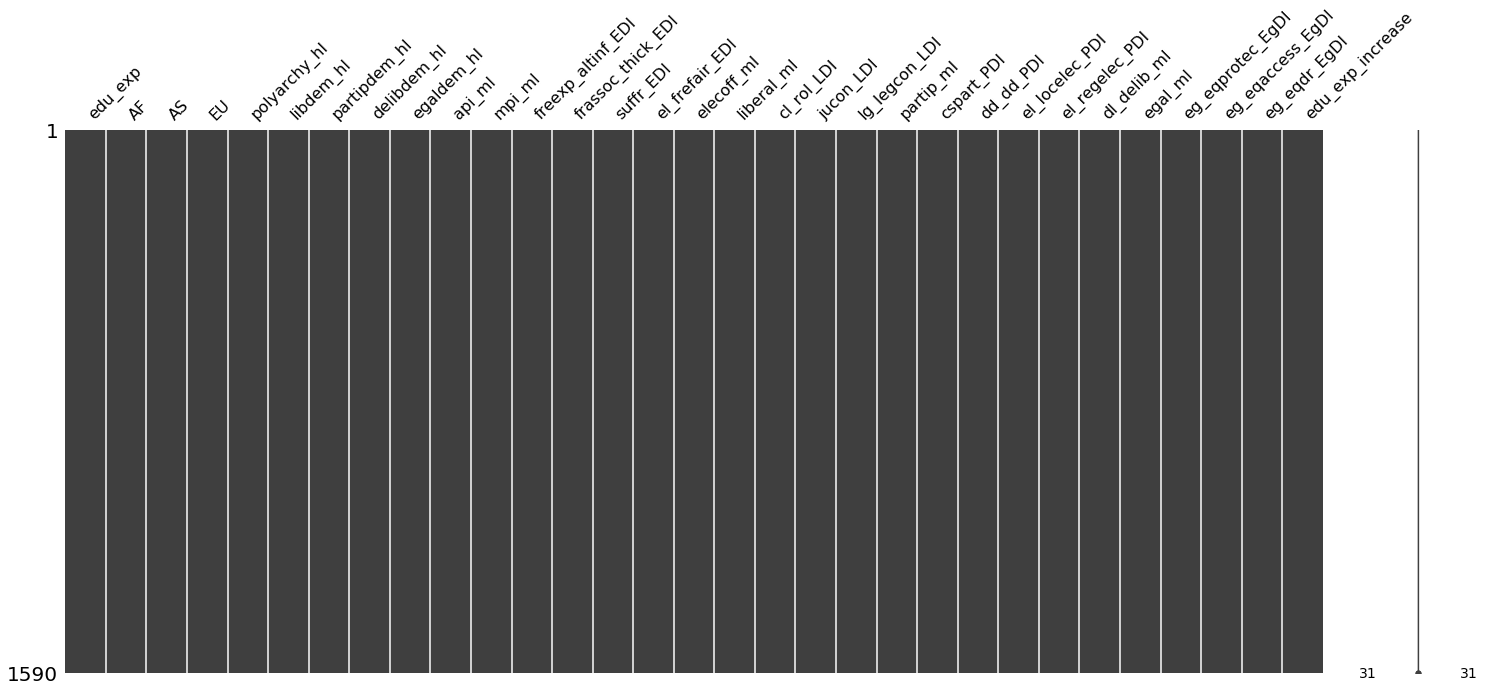

In [296]:
# check for missingness
miss.matrix(df_ml2)

### Split Data

#### Pick only the High-Level indices as predictors.

In [540]:
y = df_ml2[['edu_exp_increase']]
X = df_ml2[['polyarchy_hl','libdem_hl','partipdem_hl','delibdem_hl','egaldem_hl','AF','AS','EU']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [541]:
print(train_X.shape[0]/df_ml2.shape[0])
print(test_X.shape[0]/df_ml2.shape[0])

0.7496855345911949
0.25031446540880503


In [542]:
# view training data
train_X.head()

polyarchy_hl  libdem_hl  partipdem_hl  delibdem_hl  \
country     year                                                       
austria     2014         0.874      0.790         0.658        0.787   
india       2004         0.767      0.605         0.507        0.701   
vietnam     2012         0.231      0.119         0.200        0.172   
syria       2006         0.153      0.050         0.049        0.034   
switzerland 2006         0.880      0.838         0.777        0.836   

                  egaldem_hl  AF  AS  EU  
country     year                          
austria     2014       0.766   0   0   1  
india       2004       0.514   0   1   0  
vietnam     2012       0.226   0   1   0  
syria       2006       0.094   0   1   0  
switzerland 2006       0.815   0   0   1

### Explore the training data 

In [302]:
# Look at the training data
train_X.shape 

(1192, 8)

In [303]:
train_y.min()

edu_exp_increase    0.0
dtype: float64

In [304]:
train_y.max()

edu_exp_increase    1.0
dtype: float64

How is the data distributed?

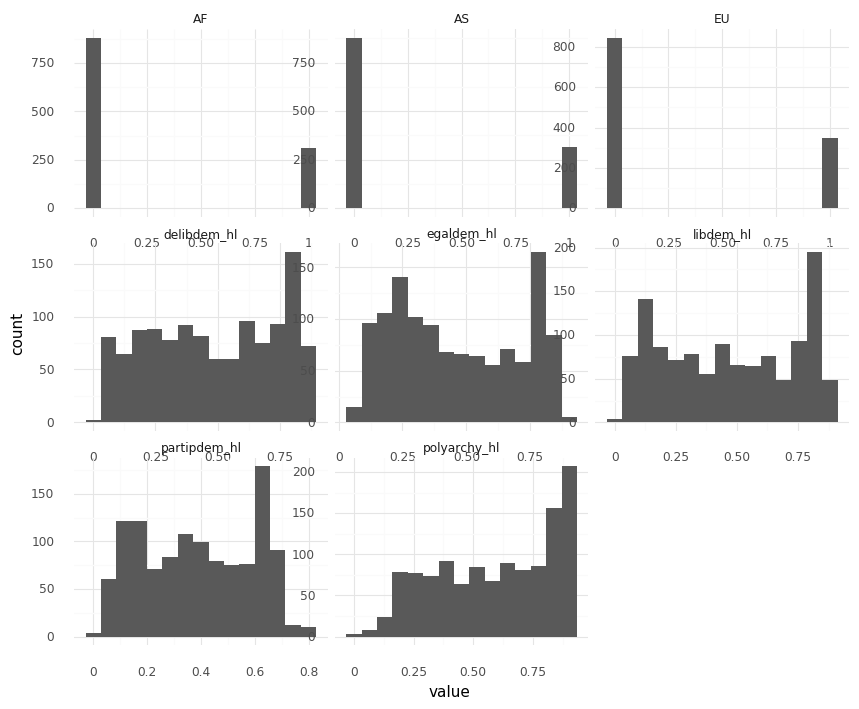

<ggplot: (-9223371940650082272)>

In [305]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All high-level indices are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp_increase` and see if there are any red flags. 

Text(0.5, 1.0, 'Distribution of Outcome')

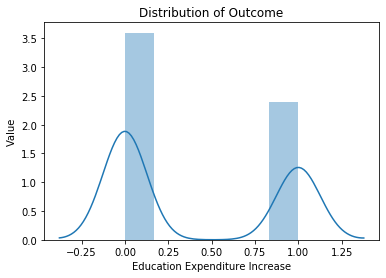

In [306]:
# Seaborn
ax = sns.distplot(train_y.edu_exp_increase,hist=True,kde=True)
ax.set(xlabel="Education Expenditure Increase", ylabel = "Value")
ax.set_title("Distribution of Outcome")

Let's just look at how our predictors relate to the outcome.

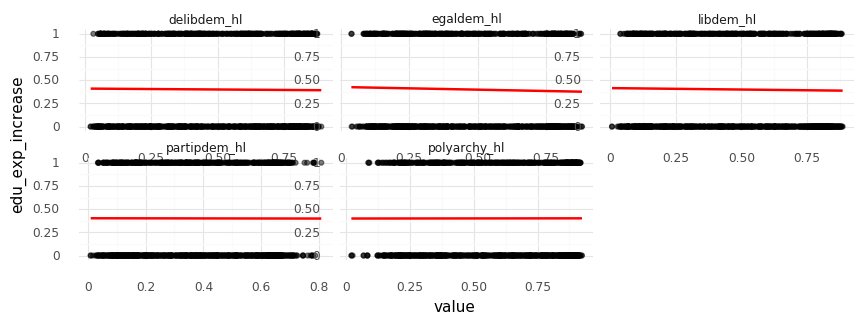

<ggplot: (-9223371940651346172)>

In [310]:
D = train_X.copy()
D = D[['delibdem_hl','egaldem_hl','libdem_hl','partipdem_hl','polyarchy_hl']]
D['edu_exp_increase'] = train_y

(
    ggplot(D.melt(id_vars=["edu_exp_increase"]),
           aes(x="value",y="edu_exp_increase"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

All our predictors seem to have close a fairly positive relationship with the outcome. Let's see which one of these indeces matter the most for an increase in education spending. 

## Train Models

### Cross Validation 

In [543]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [544]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [545]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNNd()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTd()],
     'model__max_depth':[2,3,4,5,6,7,8,9,10]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RFd()],
    'model__max_depth':[2,3,4,8],
    'model__n_estimators':[500,1000,1500,1600],
    'model__max_features':[2,3,4,5]}
        
]

## Run Models

Put it all together in a GridSearch

In [546]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

And Run

In [547]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50, 100]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=4,
                                                           n_estimators=1000)],
                          'model__max_depth': [2, 3, 4, 8],
                          'model__max_features': [2, 3, 4, 5],
                          'model__n_estimators': [500, 1000, 1500, 1600]}],
             scoring='roc_a

### Model Performance

In [552]:
# Find the best AUC score
print(search.best_score_)

0.578999248256822


In [553]:
# Find the model associated with the best score
print(search.best_params_)

{'model': RandomForestClassifier(max_depth=8, max_features=4, n_estimators=1000), 'model__max_depth': 8, 'model__max_features': 4, 'model__n_estimators': 1000}


In [554]:
# Store the best estimator
rf_mod = search.best_estimator_

In [557]:
# Look at auc on the training data
print(m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1]))

0.9499743443139669


In [559]:
# accuracy
print(m.accuracy_score(train_y,rf_mod.predict(train_X)))

0.8120805369127517


In [561]:
# Look at auc on the test data
print(m.roc_auc_score(test_y,rf_mod.predict_proba(test_X)[:,1]))

0.6007587137510502


In [564]:
# accuracy
print(m.accuracy_score(test_y,rf_mod.predict(test_X)))

0.6030150753768844


In [568]:
# For comparison, look at the value counts of the our target variable
print(test_y['edu_exp_increase'].value_counts())

0.0    217
1.0    181
Name: edu_exp_increase, dtype: int64


In [569]:
181/(181+217)

0.4547738693467337

We can see that the best model appears to be a random forest classifier with four features per tree, a depth of 8, and 1000 trees grown. This model has an AUC of 0.58 using 5-fold cross validation. On the test data, the model has an AUC of 0.60 and an accuracy of 0.60. We can see that in the test target variable, roughly 45% of observations have a value of 1, so this model does seem to be an improvement over simply predicting a value of 1 for every observation.

#### Generate a ROC curve plot. 

First, we need the model to return probabilities not predictions. 

In [570]:
probs = rf_mod.predict_proba(test_X)
probs = pd.DataFrame(probs,columns=rf_mod.classes_)
probs

0.0       1.0
0    0.577626  0.422374
1    0.458603  0.541397
2    0.653442  0.346558
3    0.749135  0.250865
4    0.550754  0.449246
..        ...       ...
393  0.518149  0.481851
394  0.228470  0.771530
395  0.527743  0.472257
396  0.684141  0.315859
397  0.646884  0.353116

[398 rows x 2 columns]

In [571]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

In [572]:
probs[1]

0      0.422374
1      0.541397
2      0.346558
3      0.250865
4      0.449246
         ...   
393    0.481851
394    0.771530
395    0.472257
396    0.315859
397    0.353116
Name: 1.0, Length: 398, dtype: float64

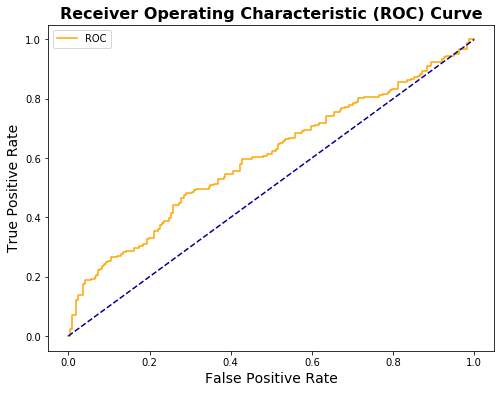

In [573]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [574]:
# Calculate area under ROC curve
search.best_score_

0.578999248256822

The bigger the area covered (AUC), the better the machine learning model is at distinguishing the given classes. The ideal value for AUC being 1, our model is far from the best-case scenario since it is only 57.9% accurate for instances and their classifications. Our model's AUC is close to 0.5, which is when both the class distributions simply mimic each other (i.e. the model has no discrimination capabilities at all). However, since our AUC is above 0.5, we can say that it does have some discrimination capabilities. In other words, it performs better than chance (50%), albeit slightly.


# Model Interpretation

## Permutation Importance

### with `sklearn`
<br>

Examine variable importance i.e. which variables does the model rely on most when making predictions? 

Permute the features to determine importance. Note here that I only do this 5 times for the sake of runtime, but you'd want to do this more (e.g. 30 times)

In [575]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

Organize the output as a data frame. 

In [576]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals (2 S.D below and above)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view dataframe
vi_dat

variable        vi       std       low      high
0   delibdem_hl  0.115744  0.007153  0.101438  0.130050
1  partipdem_hl  0.078412  0.006421  0.065570  0.091254
2  polyarchy_hl  0.071085  0.008125  0.054835  0.087335
3    egaldem_hl  0.057998  0.005296  0.047406  0.068589
4     libdem_hl  0.056012  0.006033  0.043947  0.068078
5            EU  0.021952  0.002866  0.016220  0.027684
6            AF  0.004642  0.001258  0.002126  0.007158
7            AS  0.003971  0.001369  0.001233  0.006709

Visualize

In [577]:
# Plot
plot_ml1_vi = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="Predictors",title="Variable Importance")
)


# save plot
plot_ml1_vi.save("plot_ml1_vi.png", dpi =300)

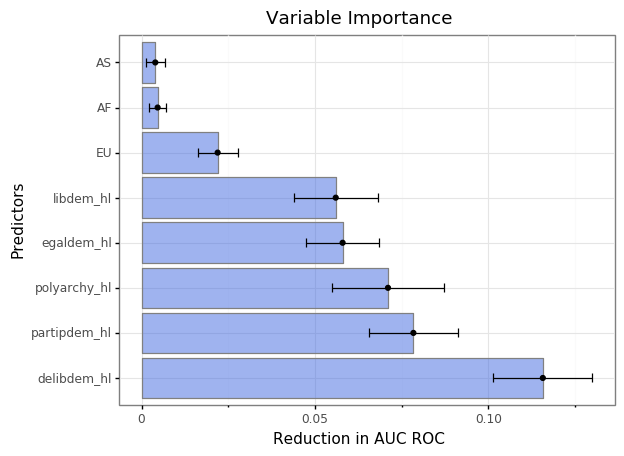

<ggplot: (-9223371940632124052)>

In [578]:
plot_ml1_vi

Delibdem_hl matters the most, followed by partipdem_hl and polyarchy_hl.

**Deliberative Democracy Index**:
<br>
Question: To what extent is the ideal of deliberative democracy achieved?
<br>
Clarification: The deliberative principle of democracy focuses on the process by which decisions are reached in a polity. A deliberative process is one in which public reasoning focused on the common good motivates political decisions—as contrasted with emotional appeals, solidary attachments, parochial interests, or coercion. According to this principle, democracy requires more than an aggregation of existing preferences. There should also be respectful dialogue at all levels—from preference formation to final decision—among informed and competent participants who are open to persuasion. To make it a measure of not only the deliberative principle but also of democracy, the index also takes the level of electoral democracy into account.


### with `eli5`

Initialize the `PermutationImportance` class object. 

In [579]:
perm_train = PermutationImportance(rf_mod,
                                   n_iter=5,random_state=123)

Fit it using the train (or test!) data

In [580]:
perm_train.fit(train_X,train_y)

PermutationImportance(estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                                ('model',
                                                 RandomForestClassifier(max_depth=8,
                                                                        max_features=4,
                                                                        n_estimators=1000))]),
                      random_state=123)

We can immediately extract the weights as a data frame. 

In [581]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))
vi2

feature    weight       std
0   delibdem_hl  0.116275  0.005348
1  partipdem_hl  0.081711  0.005555
2  polyarchy_hl  0.072315  0.006507
3     libdem_hl  0.053691  0.002313
4    egaldem_hl  0.051510  0.005899
5            EU  0.024329  0.003227
6            AF  0.004195  0.002188
7            AS  0.003691  0.001007

We can then just plot as we did above. 

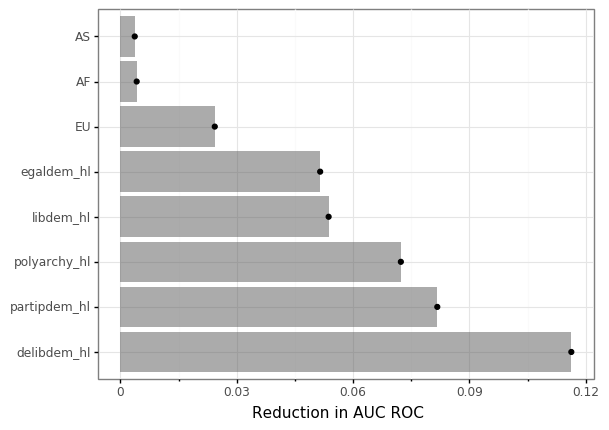

<ggplot: (-9223371940649468984)>

In [582]:
# Plot
(
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5) +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

Same results as before.

## ICE Plots

### with `pdpbox`

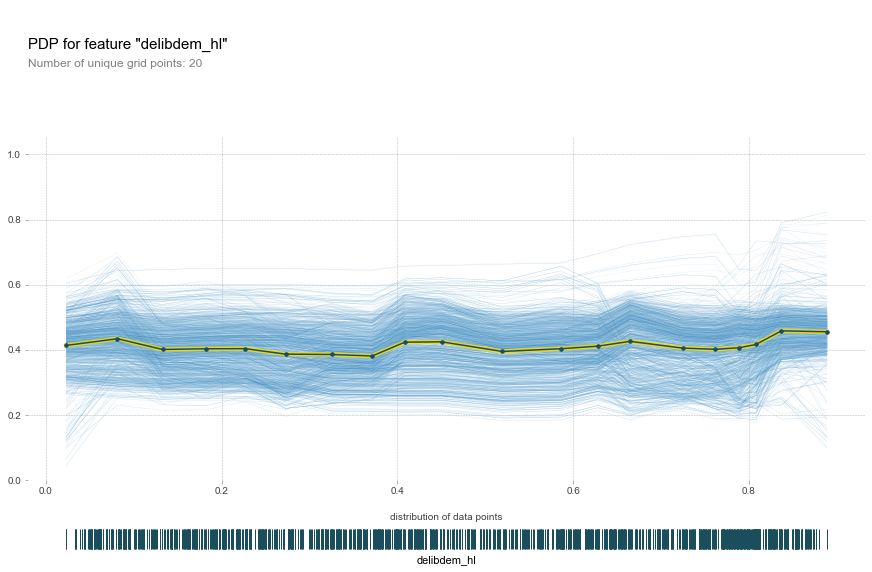

In [583]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="delibdem_hl",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'delibdem_hl',plot_pts_dist=True,
                      center=False,plot_lines=True, # ICE part                          
                      figsize=(15,10))

**centering** the plot around the baseline (minimum) value of the variable of interest. 

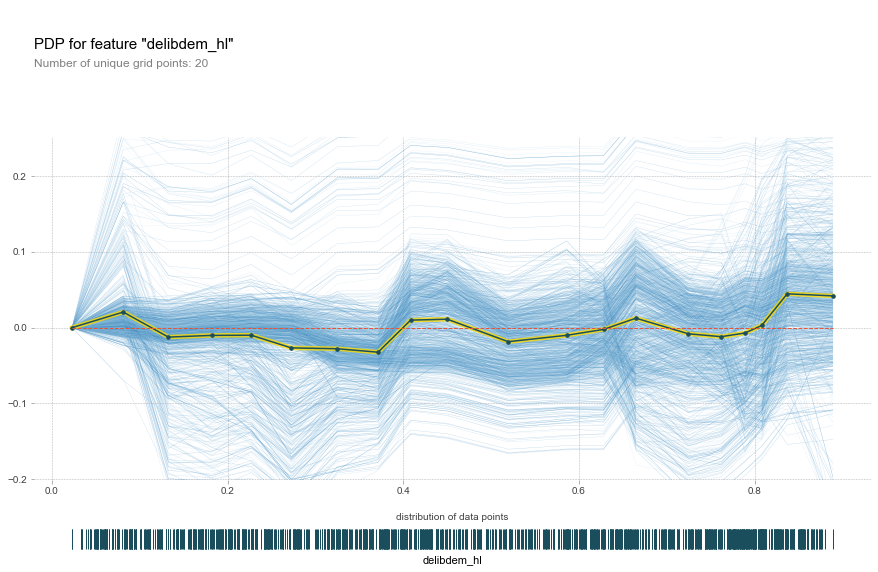

In [584]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="delibdem_hl",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'delibdem_hl',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

There's evidence here that there is a lot of heterogeneity (or a lot of interaction) in this model since generally the data is not moving in the same flow.  

## Partial Dependency Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

### with `sklearn`

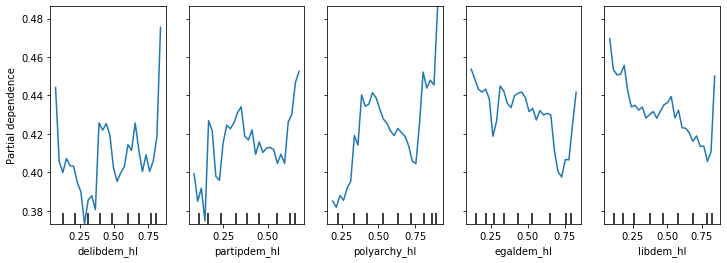

In [585]:
# Target specific features
features = ['delibdem_hl','partipdem_hl','polyarchy_hl','egaldem_hl','libdem_hl']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

At really low as well as really high levels of deliberative democracy, the probability of an increase in educational spending is the highest and approximately the same i.e. 45%. In between there is a wide variation.

The graph for participatory democracy shows that generally, as participatory democracy levels increase, the probability of an increase in educational spending also goes up (a difference of around 7% between the highest and lowest levels of perticipatory demcoracy levels). 

The same is true for the electoral democracy index.

However, for both egalitarian democracy index and liberal democracy index, the probability of an increase in educational spending seems to decrease as the levels of these indices increase. This is more pronounced in the liberal democracy index as compared to the egalitarian democracy index.

#### First fit the partial dependencies. 

In [586]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="delibdem_hl")

Then plot them.

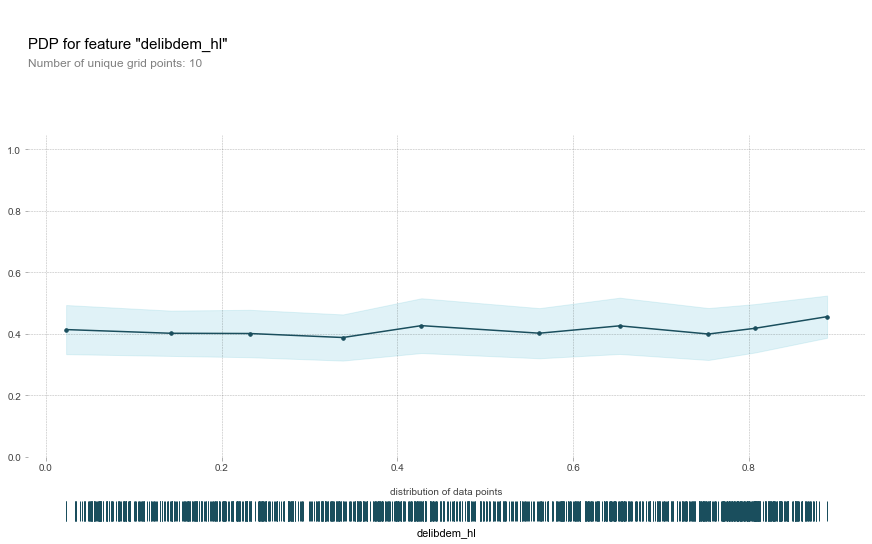

In [587]:
fig,ax = pdp.pdp_plot(pdp_dist,'delibdem_hl',plot_pts_dist=True,center=False,)

# light blue = ICE plot

At low levels of this index, an increase reduces the probability of an increase in education expenditure. Heterogenous effect of deliberative democracy.

#### Interaction Partial Dependency Plots (2D)
Check interaction between the two most important variables - plot the interactions as a grid (which are more interpretable)

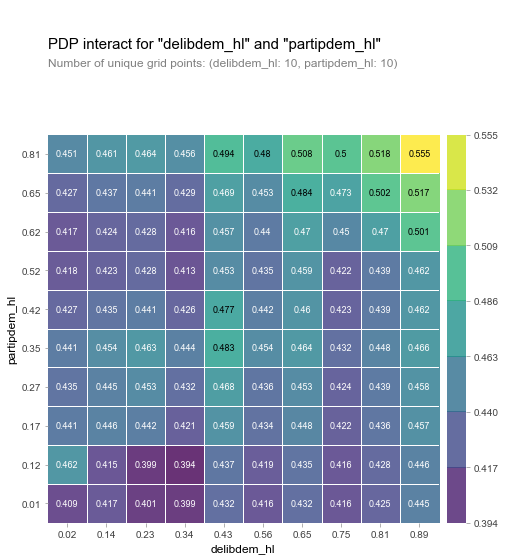

In [588]:
# plotting interaction as a grid - delibdem_hl and partipdem_hl
inter1  =  pdp.pdp_interact(model = rf_mod, 
                            dataset = train_X,
                            model_features = train_X.columns,
                            features=["delibdem_hl",'partipdem_hl'])

fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                               feature_names=["delibdem_hl",'partipdem_hl'],
                               plot_type="grid")

This graph shows predictions for any combination of delibdem_hl and partipde_hl.
We see the highest predictions when both delibdem_hl and partipdem_hl are the highest.

At high levels of delibdem_hl, high values of partipdem_hl improve the probability of an increase in education expenditure

## <center> <font color='green'>Second Machine Learning Model </font>

Outcome: Increase in education expenditure
<br>
Predictors: Low-Level Indices

In [722]:
# create a copy of df_hl
df_ml3 = df_hl.copy()

In [723]:
df_ml3.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  api_ml  ...  partip_ml  cspart_PDI  \
country     year                                   ...                          
afghanistan 2010        0.319       0.215   0.643  ...      0.297       0.656   
            2011        0.314       0.223   0.653  ...      0.297       0.656   
            2012        0.352       0.228   0.643  ...      0.297       0.656   
            2013        0.313       0.225   0.637  ...      0.285       0.680   
            2014        0.354       0.239   0.666  ...      0.285       0.680   

                  dd_dd_PDI  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  \
country     year                                                           
afghanistan 2010       0.02           0.007           0.190        0.776   
            2011       0.02           0.007           0.190        0.760   
            2012       0.02           0.007           0.190        0.807   
            2013       0.02           0.106           0.134        0.754   
            2014       0.02           0.106           0.134        0.753   

                  egal_ml  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  
country     year                                                             
afghanistan 2010    0.467             0.537             0.547         0.405  
            2011    0.467             0.537             0.547         0.405  
            2012    0.467             0.537             0.547         0.405  
            2013    0.504             0.536             0.575         0.344  
            2014    0.483             0.498             0.575         0.323  

[5 rows x 30 columns]

In [724]:
# create new column that calculates the difference between edu_exp by country-year.

df_ml3['edu_exp_diff'] = np.nan 

for idx in df_ml3.index.levels[0]:
    df_ml3.edu_exp_diff[idx] = df_ml3.edu_exp[idx].diff()

In [725]:
# replace missing values with 0
df_ml3['edu_exp_diff'] = df_ml3['edu_exp_diff'].replace(np.nan, 0)

# set increase (positive number) to 1, decrease/no change to 0
df_ml3['edu_exp_diff'][df_ml3['edu_exp_diff'] <= 0] = 0
df_ml3['edu_exp_diff'][df_ml3['edu_exp_diff'] > 0] = 1

In [726]:
# rename column
df_ml3.rename(columns={'edu_exp_diff': 'edu_exp_increase'}, inplace=True)

In [727]:
df_ml3.head()

edu_exp  AF  AS  EU  polyarchy_hl  libdem_hl  partipdem_hl  \
country     year                                                               
afghanistan 2010     3.48   0   1   0         0.362      0.238         0.156   
            2011     3.46   0   1   0         0.369      0.241         0.158   
            2012     2.60   0   1   0         0.371      0.242         0.160   
            2013     3.45   0   1   0         0.362      0.232         0.152   
            2014     3.70   0   1   0         0.403      0.262         0.164   

                  delibdem_hl  egaldem_hl  api_ml  ...  cspart_PDI  dd_dd_PDI  \
country     year                                   ...                          
afghanistan 2010        0.319       0.215   0.643  ...       0.656       0.02   
            2011        0.314       0.223   0.653  ...       0.656       0.02   
            2012        0.352       0.228   0.643  ...       0.656       0.02   
            2013        0.313       0.225   0.637  ...       0.680       0.02   
            2014        0.354       0.239   0.666  ...       0.680       0.02   

                  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  egal_ml  \
country     year                                                         
afghanistan 2010           0.007           0.190        0.776    0.467   
            2011           0.007           0.190        0.760    0.467   
            2012           0.007           0.190        0.807    0.467   
            2013           0.106           0.134        0.754    0.504   
            2014           0.106           0.134        0.753    0.483   

                  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  \
country     year                                                     
afghanistan 2010             0.537             0.547         0.405   
            2011             0.537             0.547         0.405   
            2012             0.537             0.547         0.405   
            2013             0.536             0.575         0.344   
            2014             0.498             0.575         0.323   

                  edu_exp_increase  
country     year                    
afghanistan 2010               0.0  
            2011               0.0  
            2012               0.0  
            2013               1.0  
            2014               1.0  

[5 rows x 31 columns]

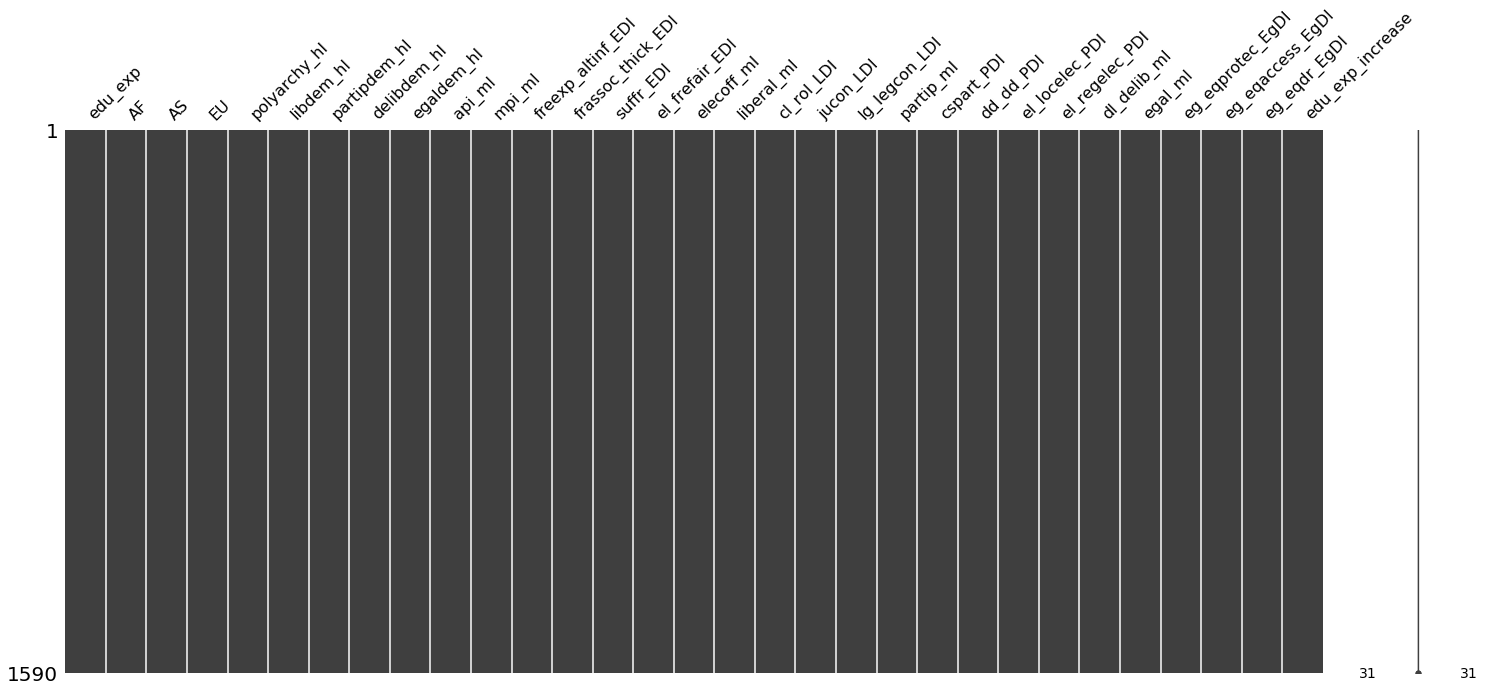

In [728]:
# check for missingness
miss.matrix(df_ml3)

### Split Data

#### Pick only the Low-Level indices as predictors.

In [596]:
df_ml3.columns

Index(['edu_exp', 'AF', 'AS', 'EU', 'polyarchy_hl', 'libdem_hl',
       'partipdem_hl', 'delibdem_hl', 'egaldem_hl', 'api_ml', 'mpi_ml',
       'freexp_altinf_EDI', 'frassoc_thick_EDI', 'suffr_EDI', 'el_frefair_EDI',
       'elecoff_ml', 'liberal_ml', 'cl_rol_LDI', 'jucon_LDI', 'lg_legcon_LDI',
       'partip_ml', 'cspart_PDI', 'dd_dd_PDI', 'el_locelec_PDI',
       'el_regelec_PDI', 'dl_delib_ml', 'egal_ml', 'eg_eqprotec_EgDI',
       'eg_eqaccess_EgDI', 'eg_eqdr_EgDI', 'edu_exp_increase'],
      dtype='object')

In [729]:
y = df_ml3[['edu_exp_increase']]
X = df_ml3[['freexp_altinf_EDI', 'frassoc_thick_EDI', 'suffr_EDI', 'el_frefair_EDI','cl_rol_LDI', 'jucon_LDI',
            'lg_legcon_LDI','cspart_PDI', 'dd_dd_PDI', 'el_locelec_PDI','el_regelec_PDI','eg_eqprotec_EgDI',
            'eg_eqaccess_EgDI', 'eg_eqdr_EgDI','AF','AS','EU']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [730]:
print(train_X.shape[0]/df_ml3.shape[0])
print(test_X.shape[0]/df_ml3.shape[0])

0.7496855345911949
0.25031446540880503


In [599]:
# view training data
train_X.head()

freexp_altinf_EDI  frassoc_thick_EDI  suffr_EDI  \
country     year                                                    
austria     2014              0.950              0.891        1.0   
india       2004              0.882              0.817        1.0   
vietnam     2012              0.197              0.059        1.0   
syria       2006              0.058              0.071        1.0   
switzerland 2006              0.971              0.915        1.0   

                  el_frefair_EDI  cl_rol_LDI  jucon_LDI  lg_legcon_LDI  \
country     year                                                         
austria     2014           0.944       0.967      0.924          0.893   
india       2004           0.858       0.729      0.762          0.817   
vietnam     2012           0.482       0.568      0.206          0.239   
syria       2006           0.077       0.230      0.099          0.088   
switzerland 2006           0.938       0.979      0.986          0.942   

                  cspart_PDI  dd_dd_PDI  el_locelec_PDI  el_regelec_PDI  \
country     year                                                          
austria     2014       0.956      0.193           0.971           0.968   
india       2004       0.818      0.000           0.785           0.975   
vietnam     2012       0.793      0.020           0.922           0.931   
syria       2006       0.068      0.176           0.035           0.098   
switzerland 2006       0.961      0.679           0.991           0.992   

                  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  AF  AS  EU  
country     year                                                                
austria     2014             0.924             0.776         0.951   0   0   1  
india       2004             0.659             0.804         0.364   0   1   0  
vietnam     2012             0.798             0.584         0.760   0   1   0  
syria       2006             0.406             0.131         0.358   0   1   0  
switzerland 2006             0.926             0.946         0.962   0   0   1

### Explore the training data 

In [600]:
# Look at the training data
train_X.shape 

(1192, 17)

In [420]:
train_y.min()

edu_exp_increase    0.0
dtype: float64

In [421]:
train_y.max()

edu_exp_increase    1.0
dtype: float64

How is the data distributed?

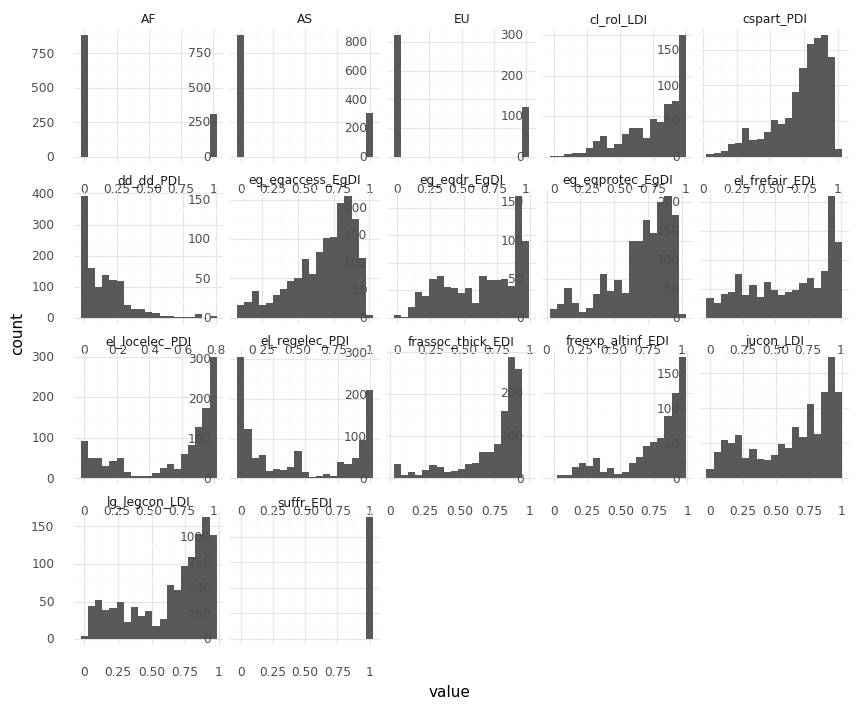

<ggplot: (-9223371940656676416)>

In [422]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All low-level indices are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp_increase` and see if there are any red flags. 

Text(0.5, 1.0, 'Distribution of Outcome')

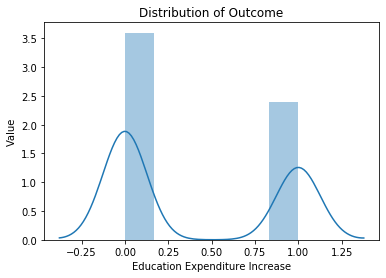

In [423]:
# Seaborn
ax = sns.distplot(train_y.edu_exp_increase,hist=True,kde=True)
ax.set(xlabel="Education Expenditure Increase", ylabel = "Value")
ax.set_title("Distribution of Outcome")

## Train Models

### Cross Validation 

In [731]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [732]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [733]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNNd()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTd()],
     'model__max_depth':[2,3,4,5,6,7,8,9,10]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RFd()],
    'model__max_depth':[2,3,4,8],
    'model__n_estimators':[500,1000,1500,1600],
    'model__max_features':[2,3,4,5,10]}
        
]

## Run Models

Put it all together in a GridSearch

In [734]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

And Run

In [754]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50, 100]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=4,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 3, 4, 8],
                          'model__max_features': [2, 3, 4, 5, 10],
                          'model__n_estimators': [500, 1000, 1500, 1600]}],
             scoring='r

### Model Performance

In [755]:
# Find the best AUC score
print(search.best_score_)

0.5613207618558647


In [756]:
# Find the model associated with the best score
print(search.best_params_)

{'model': RandomForestClassifier(max_depth=8, max_features=4, n_estimators=1500), 'model__max_depth': 8, 'model__max_features': 4, 'model__n_estimators': 1500}


In [757]:
# Store the best estimator
rf_mod = search.best_estimator_

In [758]:
# Look at auc on the training data
print(m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1]))

0.9726231839439387


In [759]:
# accuracy
print(m.accuracy_score(train_y,rf_mod.predict(train_X)))

0.8498322147651006


In [760]:
# Look at auc on the test data
print(m.roc_auc_score(test_y,rf_mod.predict_proba(test_X)[:,1]))

0.550474832599231


In [761]:
# accuracy
print(m.accuracy_score(test_y,rf_mod.predict(test_X)))

0.5628140703517588


In [613]:
# For comparison, look at the value counts of the our target variable
print(test_y['edu_exp_increase'].value_counts())

0.0    217
1.0    181
Name: edu_exp_increase, dtype: int64


In [569]:
181/(181+217)

0.4547738693467337

We can see that the best model appears to be a random forest classifier with four features per tree, a depth of 8, and 1500 trees grown. This model has an AUC of 0.56 using 5-fold cross validation. On the test data, the model has an AUC of 0.55 and an accuracy of 0.56. 

#### Generate a ROC curve plot. 

First, we need the model to return probabilities not predictions. 

In [762]:
probs = rf_mod.predict_proba(test_X)
probs = pd.DataFrame(probs,columns=rf_mod.classes_)
probs

0.0       1.0
0    0.594051  0.405949
1    0.467903  0.532097
2    0.672646  0.327354
3    0.693748  0.306252
4    0.606701  0.393299
..        ...       ...
393  0.500306  0.499694
394  0.310514  0.689486
395  0.610699  0.389301
396  0.745620  0.254380
397  0.579352  0.420648

[398 rows x 2 columns]

In [763]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

In [764]:
probs[1]

0      0.405949
1      0.532097
2      0.327354
3      0.306252
4      0.393299
         ...   
393    0.499694
394    0.689486
395    0.389301
396    0.254380
397    0.420648
Name: 1.0, Length: 398, dtype: float64

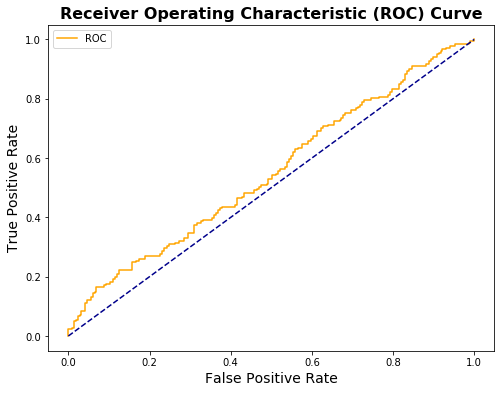

In [765]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [766]:
# Calculate area under ROC curve
search.best_score_

0.5613207618558647

The bigger the area covered (AUC), the better the machine learning model is at distinguishing the given classes. The ideal value for AUC being 1, our model is far from the best-case scenario since it is only 56.1% accurate for instances and their classifications. Our model's AUC is close to 0.5, which is when both the class distributions simply mimic each other (i.e. the model has no discrimination capabilities at all). However, since our AUC is above 0.5, we can say that it does have some discrimination capabilities. In other words, it performs better than chance (50%), albeit slightly.


# Model Interpretation

## Permutation Importance

### with `sklearn`
<br>

Examine variable importance i.e. which variables does the model rely on most when making predictions? 

Permute the features to determine importance. Note here that I only do this 5 times for the sake of runtime, but you'd want to do this more (e.g. 30 times)

In [767]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

Organize the output as a data frame. 

In [768]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals (2 S.D below and above)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view dataframe
vi_dat

variable        vi       std       low      high
0          cspart_PDI  0.063395  0.004125  0.055145  0.071645
1        eg_eqdr_EgDI  0.060906  0.005733  0.049439  0.072373
2      el_frefair_EDI  0.053188  0.003210  0.046768  0.059608
3           jucon_LDI  0.051846  0.003979  0.043888  0.059803
4   freexp_altinf_EDI  0.050419  0.003773  0.042874  0.057965
5    eg_eqprotec_EgDI  0.049021  0.005184  0.038654  0.059389
6          cl_rol_LDI  0.045721  0.004417  0.036888  0.054555
7           dd_dd_PDI  0.045162  0.003814  0.037534  0.052791
8       lg_legcon_LDI  0.043708  0.004446  0.034815  0.052601
9      el_regelec_PDI  0.042645  0.005057  0.032531  0.052760
10  frassoc_thick_EDI  0.042366  0.004204  0.033957  0.050775
11     el_locelec_PDI  0.042254  0.005537  0.031179  0.053328
12   eg_eqaccess_EgDI  0.026818  0.004728  0.017361  0.036274
13                 AF  0.005928  0.001677  0.002575  0.009282
14                 AS  0.003887  0.001176  0.001535  0.006239
15          suffr_EDI  0.000084  0.000332 -0.000580  0.000748
16                 EU -0.001286  0.002075 -0.005436  0.002863

Visualize

In [769]:
# Plot
plot_ml2_vi = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="Predictors",title="Variable Importance")
)


# save plot
plot_ml2_vi.save("plot_ml2_vi.png", dpi =300)

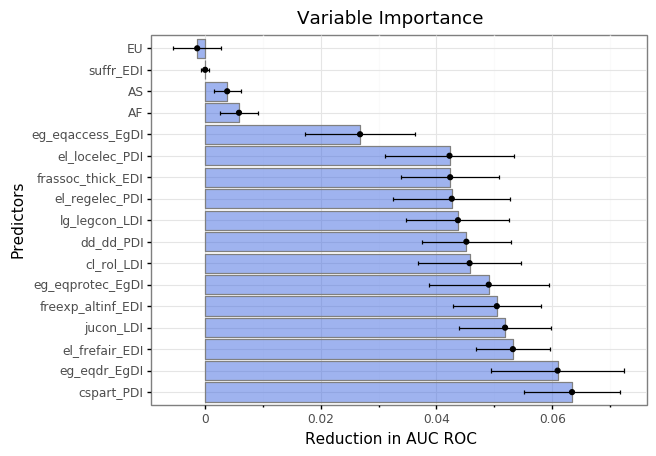

<ggplot: (-9223371940637537752)>

In [770]:
plot_ml2_vi

cspart_PDI is the most important variable for predicting an increase in education expenditure, followed by eg_eqdr_EgDI.

**cspart_PDI**: Civil society participation index
<br>
Question: Are major civil society organizations (CSOs) routinely consulted by policymakers; how large is the involvement of
people in CSOs; are women prevented from participating; and is legislative candidate nomination within party organization highly decentralized or made through party primaries?

**eg_eqdr_EgDI**: Equal distribution of resources index
<br>
Question: How equal is the distribution of resources?
<br>
Clarification: This component measures the extent to which resources — both tangible and intangible — are distributed in society. An equal distribution of resources supports egalitarian democracy in two ways. First, lower poverty rates and the distribution of goods and services such as food, water, housing, education and healthcare ensure that all individuals are capable of participating in politics and government. In short, basic needs must be met in order for individuals to effectively exercise their rights and freedoms see, for example, Sen 1999, Maslow 1943. Second, high levels of resource inequality undermine the ability of poorer populations to participate meaningfully Aristotle, Dahl 2006. Thus, it is necessary to include not only measures of poverty and the distribution of goods and services, but also the levels of inequality in these distributions, and the proportion of the population who are not eligible for social services i.e. means-tests, particularistic distribution, etc.. This principle also implies that social or economic inequalities can translate into political inequalities, an issue addressed most notably by Walzer 1983, who argues that overlapping "spheres" of inequality are particularly harmful to society. To address these overlapping "spheres", this component also includes measures of the distribution of power in society amongst different socio-economic groups, genders, etc.




## ICE Plots

### with `pdpbox`

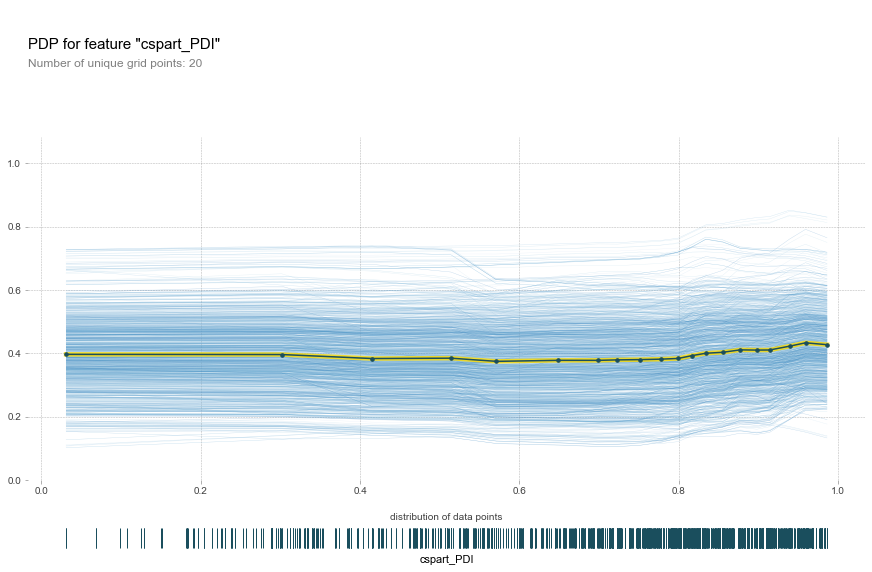

In [771]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="cspart_PDI",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'cspart_PDI',plot_pts_dist=True,
                      center=False,plot_lines=True, # ICE part                          
                      figsize=(15,10))

**centering** the plot around the baseline (minimum) value of the variable of interest. 

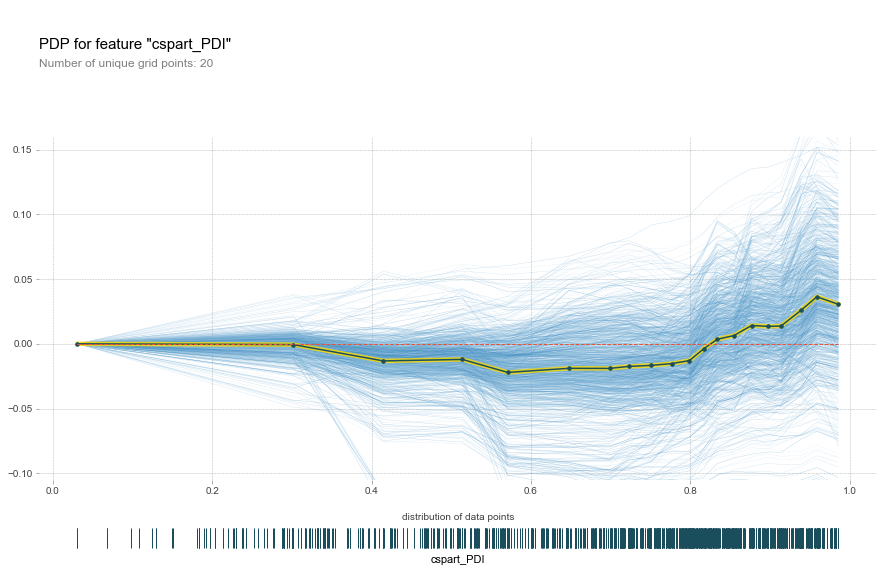

In [772]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="cspart_PDI",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'cspart_PDI',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

Not a lot of heterogeneity since generally the data is moving in the same flow.  

## Partial Dependency Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

### with `sklearn`

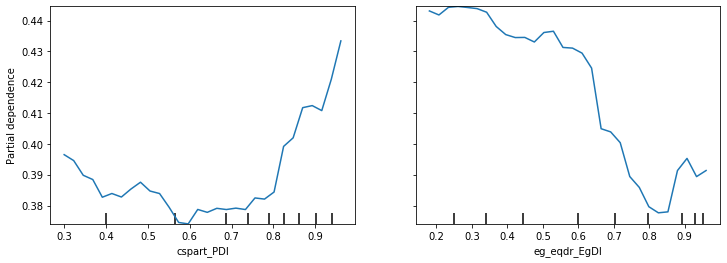

In [773]:
# Target specific features
features = ['cspart_PDI','eg_eqdr_EgDI']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

As the level of cspart increases till about 0.6, the probability of an increase in educational spending decreases, after which it starts to increase with an increase in cspart. 

The effect of eg_eqdr_EgDI on the probability of an increase in educational spending is more or less negative till aroud 0.85.

#### First fit the partial dependencies. 

In [774]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="cspart_PDI")

Then plot them.

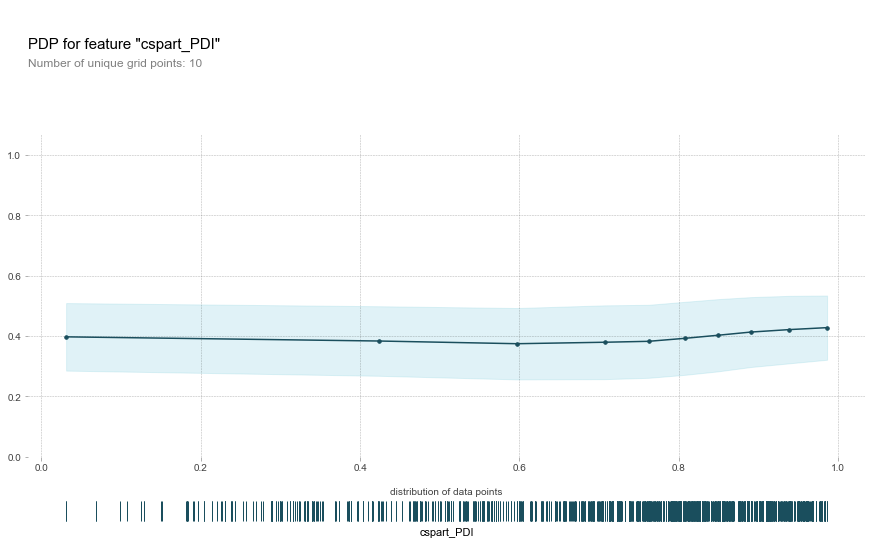

In [775]:
fig,ax = pdp.pdp_plot(pdp_dist,'cspart_PDI',plot_pts_dist=True,center=False,)

# light blue = ICE plot

Till about 0.6, an increase in cspart reduces the probability of an increase in education expenditure. After 0.6, increase in cspart increases the probability of an increase in education expenditure. 

#### Interaction Partial Dependency Plots (2D)
Check interaction between the two most important variables - plot the interactions as a grid (which are more interpretable)

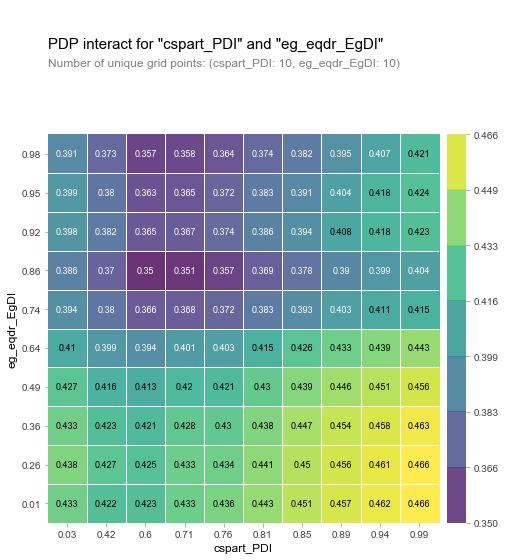

In [776]:
# plotting interaction as a grid 
inter1  =  pdp.pdp_interact(model = rf_mod, 
                            dataset = train_X,
                            model_features = train_X.columns,
                            features=["cspart_PDI",'eg_eqdr_EgDI'])

fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                               feature_names=["cspart_PDI",'eg_eqdr_EgDI'],
                               plot_type="grid")

This graph shows predictions for any combination of cspart_PDI and el_frefair_EDI.

For example, we see the highest predictions when cspart_PDI is the highest and and eg_eqdr_EgDI is the lowest.

## Global Surrogate Models

(1) Generate a vector of predictions (specifically, predicted probabilities since this is a classification problem). 

In [777]:
pr_y = rf_mod.predict_proba(train_X)[:,rf_mod.classes_ == 1]
pr_y

array([[0.49050375],
       [0.39394332],
       [0.48323692],
       ...,
       [0.24692056],
       [0.6321862 ],
       [0.56655134]])

(2) Fit the surrogate model on the predictions

In [791]:
surrogate_model = DT(max_depth=3) #regression DT
surrogate_model.fit(train_X,pr_y)

DecisionTreeRegressor(max_depth=3)

(3) Examine the model fit ($R^2$)

In [792]:
m.r2_score(pr_y,surrogate_model.predict(train_X)).round(2)

0.29

(4) Plot the tree and interpret

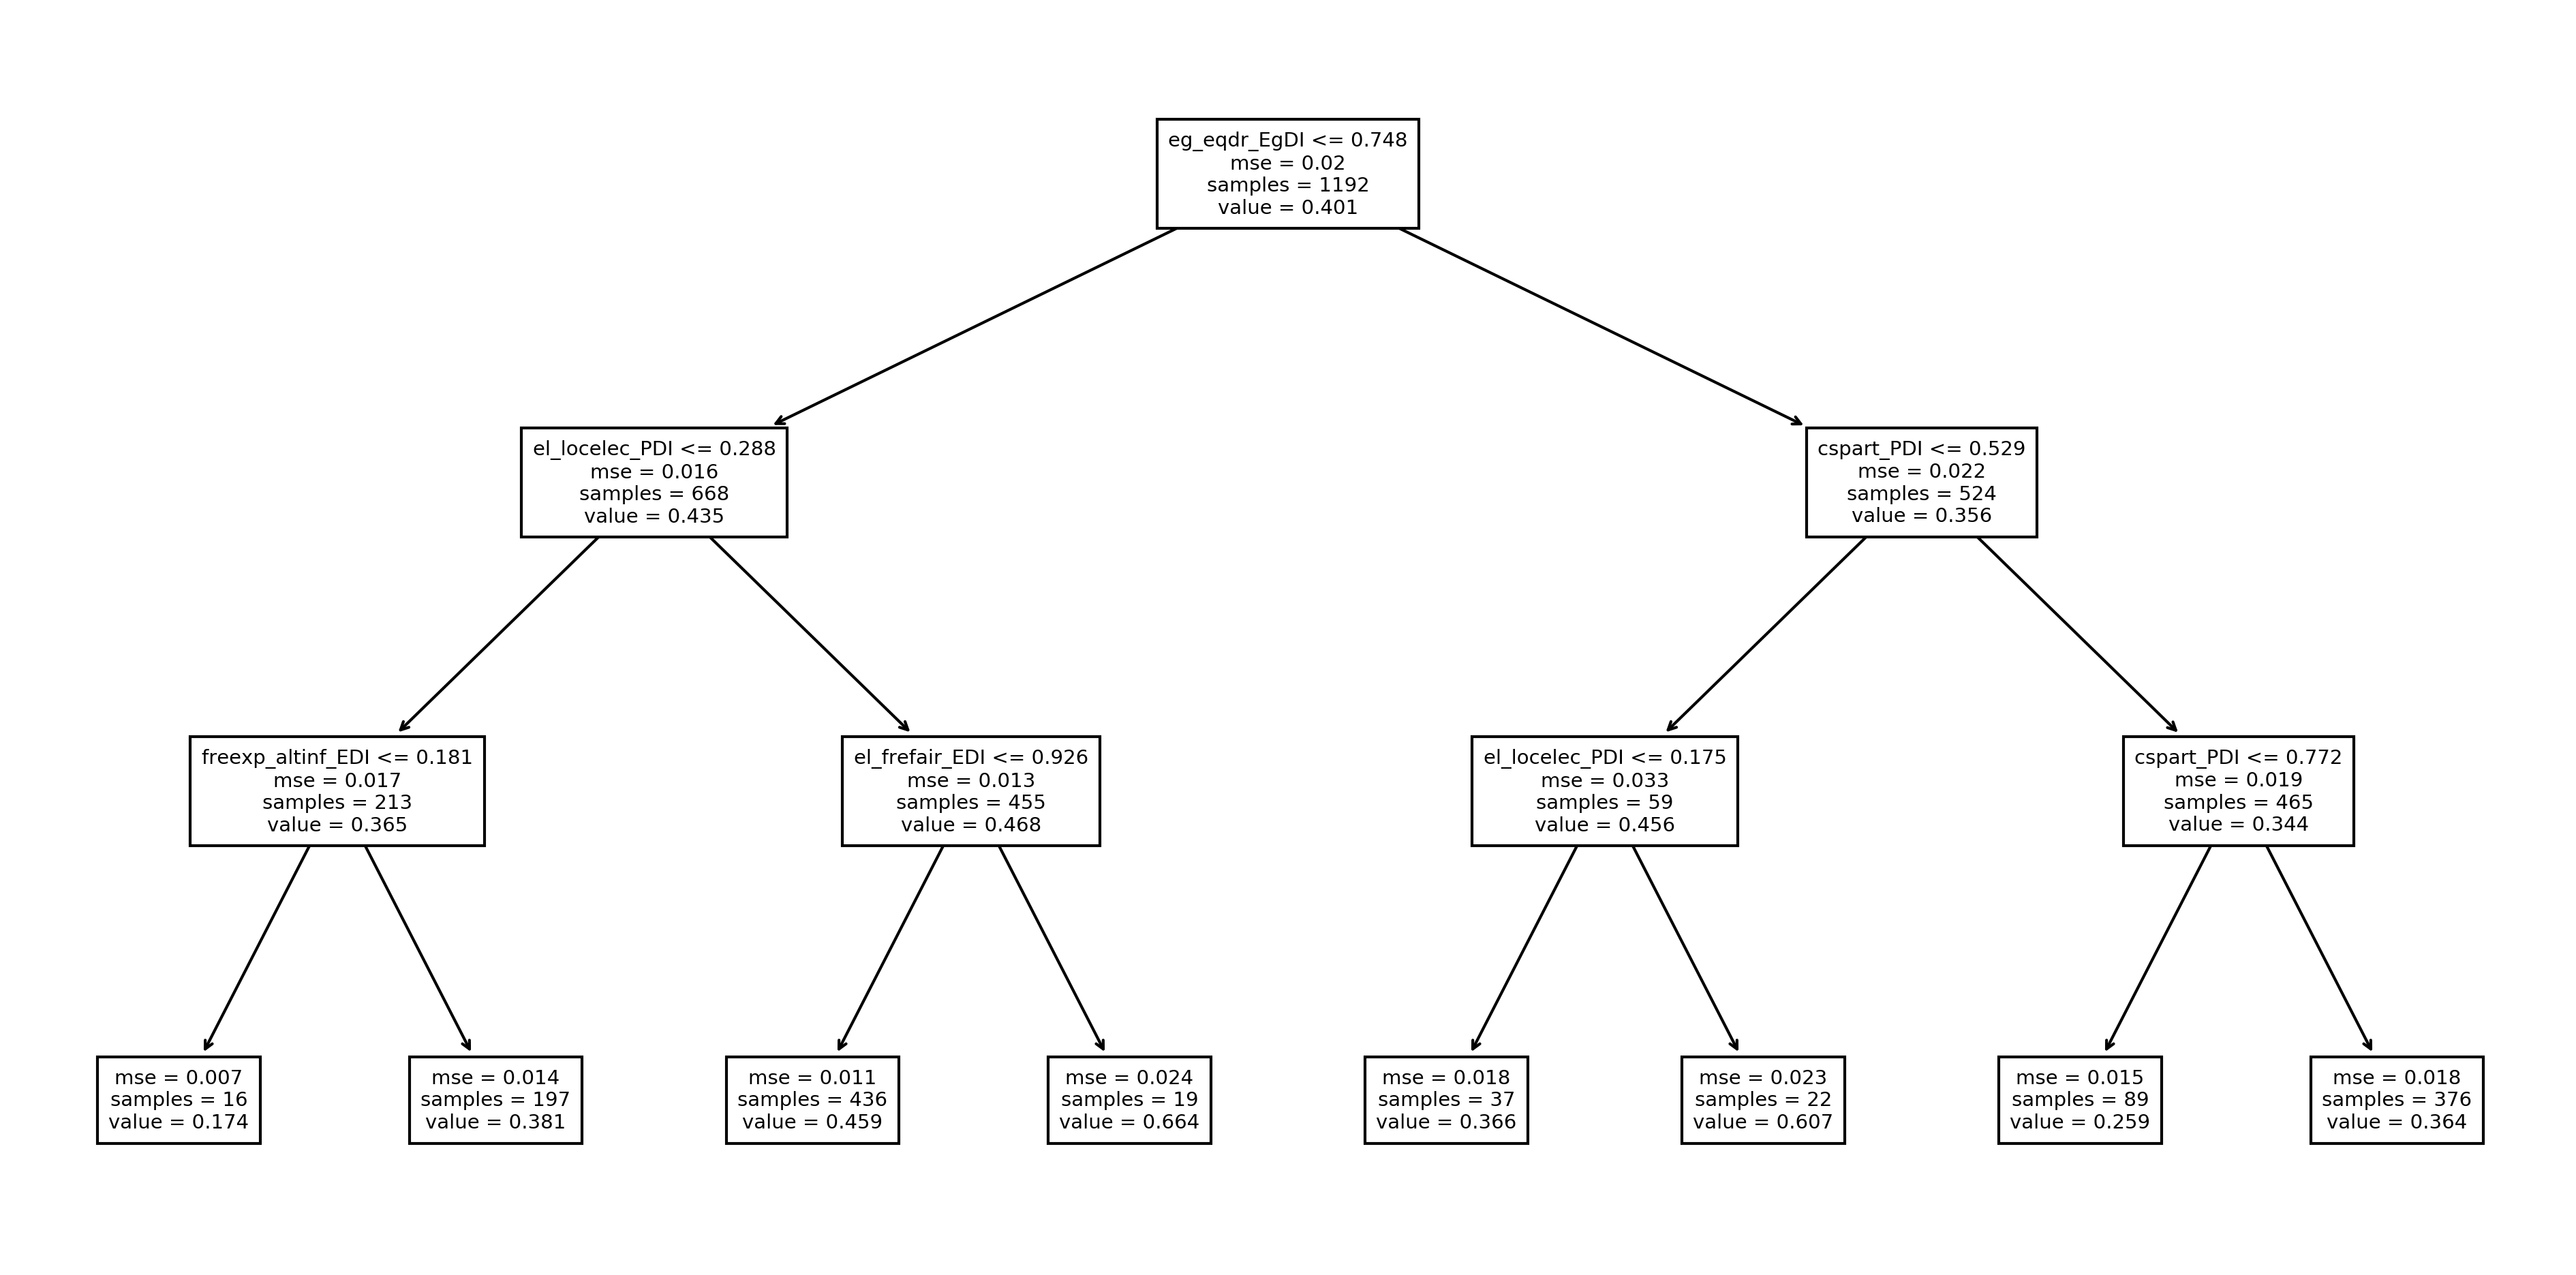

In [793]:
# Plot the tree
plt.figure(figsize=(16,8),dpi=300)
rules = tree.plot_tree(surrogate_model,feature_names=train_X.columns,fontsize=7)

## <center> <font color='green'>Third Machine Learning Model </font>

**Outcome**: Increase in education expenditure
<br>
**Predictors**: 'Other' V-Dem Indices

These are indices created using V-Dem data but that are not subcomponents of the V-Dem Democracy Indices. 

In [671]:
# create a copy of df_1
df_ml4 = df_1.copy()

In [672]:
df_ml4.head()

country  year  edu_exp  v2x_polyarchy  v2x_polyarchy_codelow  \
0  afghanistan  2010     3.48          0.362                  0.330   
1  afghanistan  2011     3.46          0.369                  0.330   
2  afghanistan  2012     2.60          0.371                  0.317   
3  afghanistan  2013     3.45          0.362                  0.317   
4  afghanistan  2014     3.70          0.403                  0.352   

   v2x_polyarchy_codehigh  v2x_polyarchy_sd  v2x_libdem  v2x_libdem_codelow  \
0                   0.387             0.029       0.238               0.211   
1                   0.424             0.045       0.241               0.217   
2                   0.416             0.053       0.242               0.204   
3                   0.399             0.058       0.232               0.190   
4                   0.457             0.054       0.262               0.229   

   v2x_libdem_codehigh  ...  v2x_divparctrl  v2x_feduni  v2xca_academ  \
0                0.265  ...           1.350       0.096           NaN   
1                0.262  ...           1.350       0.096           NaN   
2                0.263  ...           1.352       0.096           NaN   
3                0.256  ...           1.024       0.068           NaN   
4                0.284  ...           1.024       0.068           NaN   

   v2xca_academ_codelow  v2xca_academ_codehigh  v2xca_academ_sd  AF  AS  EU  \
0                   NaN                    NaN              NaN   0   1   0   
1                   NaN                    NaN              NaN   0   1   0   
2                   NaN                    NaN              NaN   0   1   0   
3                   NaN                    NaN              NaN   0   1   0   
4                   NaN                    NaN              NaN   0   1   0   

   continent  
0         AS  
1         AS  
2         AS  
3         AS  
4         AS  

[5 rows x 1803 columns]

In [673]:
# sort by country year
df_ml4.set_index(['country','year'], inplace=True)

In [674]:
# create new column that calculates the difference between edu_exp by country-year.

df_ml4['edu_exp_diff'] = np.nan 

for idx in df_ml4.index.levels[0]:
    df_ml4.edu_exp_diff[idx] = df_ml4.edu_exp[idx].diff()

In [675]:
# replace missing values with 0
df_ml4['edu_exp_diff'] = df_ml4['edu_exp_diff'].replace(np.nan, 0)

# set increase (positive number) to 1, decrease/no change to 0
df_ml4['edu_exp_diff'][df_ml4['edu_exp_diff'] <= 0] = 0
df_ml4['edu_exp_diff'][df_ml4['edu_exp_diff'] > 0] = 1

In [676]:
# rename column
df_ml4.rename(columns={'edu_exp_diff': 'edu_exp_increase'}, inplace=True)

In [677]:
df_ml4.head()

edu_exp  v2x_polyarchy  v2x_polyarchy_codelow  \
country     year                                                  
afghanistan 2010     3.48          0.362                  0.330   
            2011     3.46          0.369                  0.330   
            2012     2.60          0.371                  0.317   
            2013     3.45          0.362                  0.317   
            2014     3.70          0.403                  0.352   

                  v2x_polyarchy_codehigh  v2x_polyarchy_sd  v2x_libdem  \
country     year                                                         
afghanistan 2010                   0.387             0.029       0.238   
            2011                   0.424             0.045       0.241   
            2012                   0.416             0.053       0.242   
            2013                   0.399             0.058       0.232   
            2014                   0.457             0.054       0.262   

                  v2x_libdem_codelow  v2x_libdem_codehigh  v2x_libdem_sd  \
country     year                                                           
afghanistan 2010               0.211                0.265          0.027   
            2011               0.217                0.262          0.022   
            2012               0.204                0.263          0.029   
            2013               0.190                0.256          0.040   
            2014               0.229                0.284          0.028   

                  v2x_partipdem  ...  v2x_feduni  v2xca_academ  \
country     year                 ...                             
afghanistan 2010          0.156  ...       0.096           NaN   
            2011          0.158  ...       0.096           NaN   
            2012          0.160  ...       0.096           NaN   
            2013          0.152  ...       0.068           NaN   
            2014          0.164  ...       0.068           NaN   

                  v2xca_academ_codelow  v2xca_academ_codehigh  \
country     year                                                
afghanistan 2010                   NaN                    NaN   
            2011                   NaN                    NaN   
            2012                   NaN                    NaN   
            2013                   NaN                    NaN   
            2014                   NaN                    NaN   

                  v2xca_academ_sd  AF  AS  EU  continent  edu_exp_increase  
country     year                                                            
afghanistan 2010              NaN   0   1   0         AS               0.0  
            2011              NaN   0   1   0         AS               0.0  
            2012              NaN   0   1   0         AS               0.0  
            2013              NaN   0   1   0         AS               1.0  
            2014              NaN   0   1   0         AS               1.0  

[5 rows x 1802 columns]

In [678]:
# keep only other indicators
df_ml4 = df_ml4[['AF','AS','EU','edu_exp_increase', 'v2x_accountability_osp',
                      'v2x_ex_confidence','v2x_ex_direlect', 'v2x_ex_hereditary', 'v2x_ex_military',
                      'v2x_ex_party', 'v2x_neopat', 'v2x_civlib',
                      'v2xpe_exlecon', 'v2xpe_exlgender', 'v2xpe_exlgeo', 'v2xpe_exlpol',
                      'v2xpe_exlsocgr', 'v2x_corr', 'v2x_gender',
                      'v2x_rule', 'v2xcl_acjst', 'v2xcl_prpty', 'v2xcs_ccsi', 'v2x_EDcomp_thick', 'v2x_freexp',
                      'v2xcl_disc', 'v2xcl_dmove', 'v2xcl_slave', 'v2xps_party', 'v2xca_academ']]

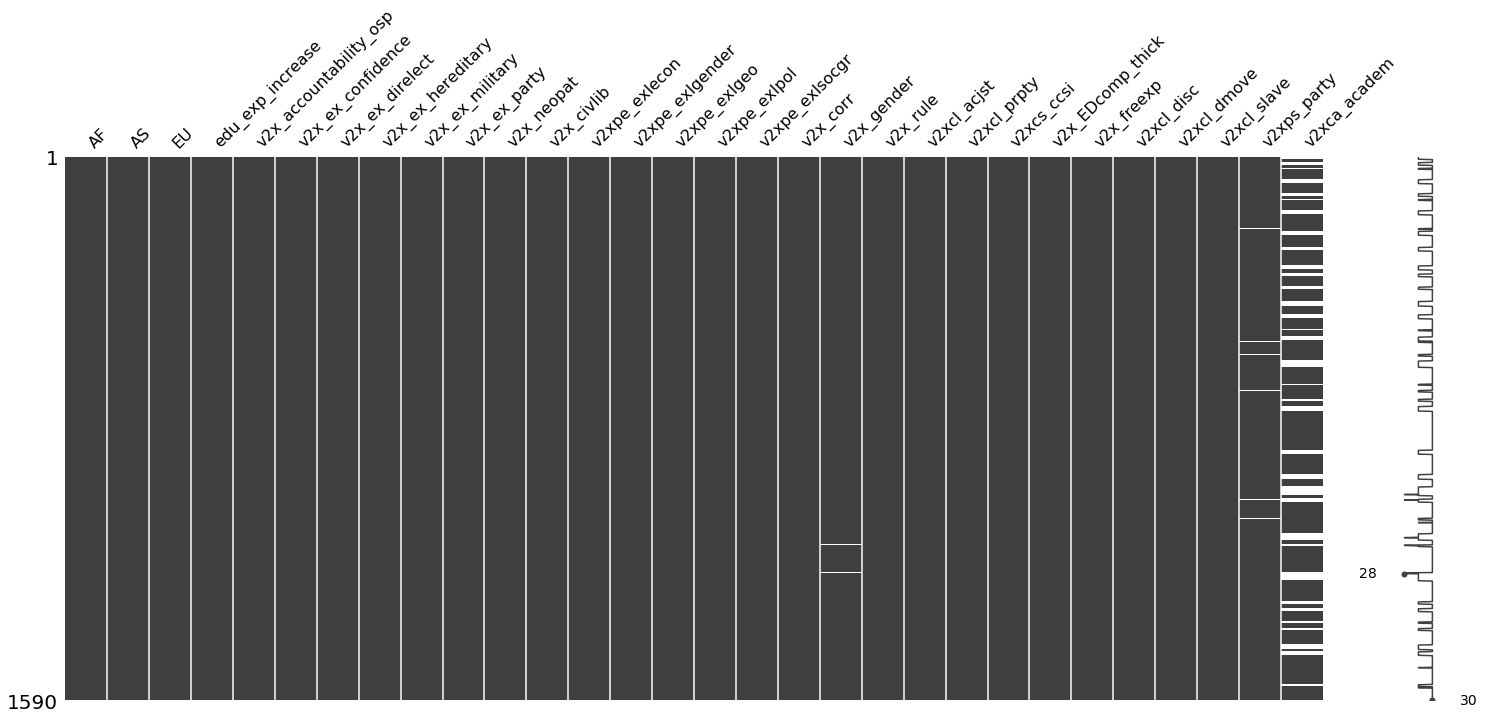

In [679]:
# check for missing data
miss.matrix(df_ml4)

Some data for v2x_gender and v2xps_party, and a lot of data for v2xca_academ is missing. Since there is a lot of missing data for the academic freedom index, it should be dropped. 

In [680]:
df_ml4 = df_ml4.drop(columns = 'v2xca_academ')

In [681]:
df_ml4.shape

(1590, 29)

In [682]:
# for the other 3, fill missing values with mean column values
df_ml4.fillna(df_ml4.mean(), inplace=True)

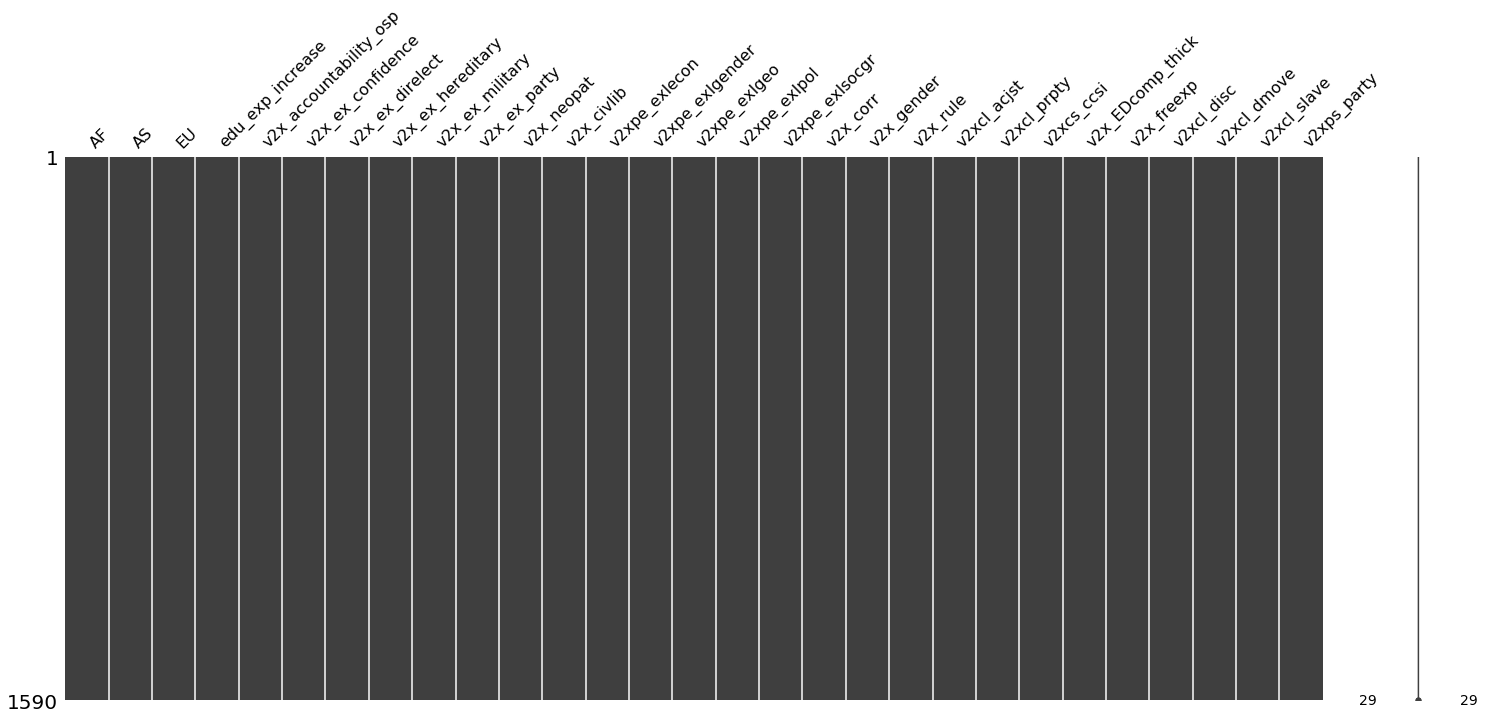

In [683]:
# check for missingness again
miss.matrix(df_ml4)

### Split Data

In [684]:
y = df_ml4[['edu_exp_increase']]
X = df_ml4.drop(columns=['edu_exp_increase'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [685]:
print(train_X.shape[0]/df_ml4.shape[0])
print(test_X.shape[0]/df_ml4.shape[0])

0.7496855345911949
0.25031446540880503


In [686]:
# view training data
train_X.head()

AF  AS  EU  v2x_accountability_osp  v2x_ex_confidence  \
country     year                                                          
austria     2014   0   0   1                   0.950              1.000   
india       2004   0   1   0                   0.918              0.667   
vietnam     2012   0   1   0                   0.368              0.000   
syria       2006   0   1   0                   0.134              0.000   
switzerland 2006   0   0   1                   0.964              0.000   

                  v2x_ex_direlect  v2x_ex_hereditary  v2x_ex_military  \
country     year                                                        
austria     2014              0.0                0.0             0.00   
india       2004              0.0                0.0             0.00   
vietnam     2012              0.0                0.0             0.00   
syria       2006              1.0                0.0             0.25   
switzerland 2006              0.0                0.0             0.00   

                  v2x_ex_party  v2x_neopat  ...  v2x_rule  v2xcl_acjst  \
country     year                            ...                          
austria     2014         0.111       0.048  ...     0.968        0.945   
india       2004         0.100       0.215  ...     0.714        0.681   
vietnam     2012         0.409       0.712  ...     0.271        0.491   
syria       2006         0.143       0.927  ...     0.099        0.134   
switzerland 2006         0.000       0.016  ...     0.992        0.978   

                  v2xcl_prpty  v2xcs_ccsi  v2x_EDcomp_thick  v2x_freexp  \
country     year                                                          
austria     2014        0.921       0.925             0.902       0.963   
india       2004        0.677       0.828             0.814       0.819   
vietnam     2012        0.562       0.361             0.343       0.344   
syria       2006        0.424       0.094             0.272       0.053   
switzerland 2006        0.868       0.930             0.900       0.979   

                  v2xcl_disc  v2xcl_dmove  v2xcl_slave  v2xps_party  
country     year                                                     
austria     2014       0.956        0.907        0.887        0.955  
india       2004       0.834        0.652        0.600        0.828  
vietnam     2012       0.529        0.799        0.672        0.656  
syria       2006       0.053        0.328        0.710        0.373  
switzerland 2006       0.959        0.863        0.900        0.906  

[5 rows x 28 columns]

### Explore the training data 

In [504]:
# Look at the training data
train_X.shape 

(1192, 42)

In [505]:
train_y.min()

edu_exp_increase    0.0
dtype: float64

In [506]:
train_y.max()

edu_exp_increase    1.0
dtype: float64

How is the data distributed?

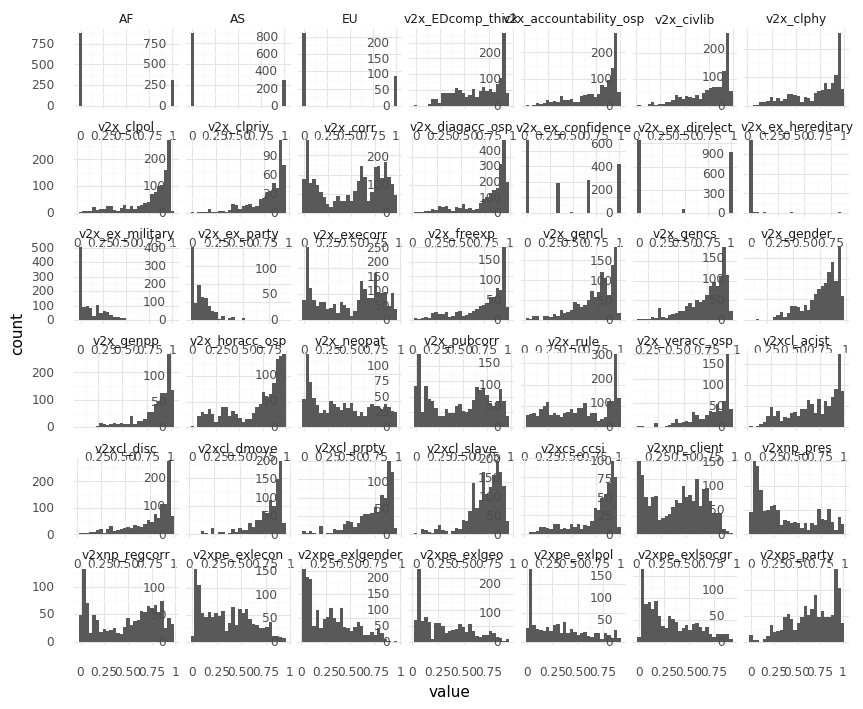

<ggplot: (-9223371940639012536)>

In [507]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All indices are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp_increase` and see if there are any red flags. 

Text(0.5, 1.0, 'Distribution of Outcome')

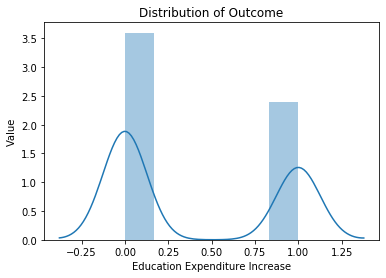

In [508]:
# Seaborn
ax = sns.distplot(train_y.edu_exp_increase,hist=True,kde=True)
ax.set(xlabel="Education Expenditure Increase", ylabel = "Value")
ax.set_title("Distribution of Outcome")

## Train Models

### Cross Validation 

In [687]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [688]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [689]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNNd()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTd()],
     'model__max_depth':[2,3,4,5,6,7,8,9,10]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RFd()],
    'model__max_depth':[2,3,4,8],
    'model__n_estimators':[500,1000,1500,1600],
    'model__max_features':[2,3,4,5]}
        
]

## Run Models

Put it all together in a GridSearch

In [690]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

And Run

In [691]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50, 100]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=1000)],
                          'model__max_depth': [2, 3, 4, 8],
                          'model__max_features': [2, 3, 4, 5],
                          'model__n_estimators': [500, 1000, 1500, 1600]}],
             scoring='roc_a

### Model Performance

In [692]:
# Find the best AUC score
print(search.best_score_)

0.5755826377867062


In [693]:
# Find the model associated with the best score
print(search.best_params_)

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=1000), 'model__max_depth': 8, 'model__max_features': 5, 'model__n_estimators': 1000}


In [694]:
# Store the best estimator
rf_mod = search.best_estimator_

In [695]:
# Look at auc on the training data
print(m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1]))

0.9638767940654734


In [696]:
# accuracy
print(m.accuracy_score(train_y,rf_mod.predict(train_X)))

0.8406040268456376


In [697]:
# Look at auc on the test data
print(m.roc_auc_score(test_y,rf_mod.predict_proba(test_X)[:,1]))

0.5479415433968989


In [698]:
# accuracy
print(m.accuracy_score(test_y,rf_mod.predict(test_X)))

0.5678391959798995


In [613]:
# For comparison, look at the value counts of the our target variable
print(test_y['edu_exp_increase'].value_counts())

0.0    217
1.0    181
Name: edu_exp_increase, dtype: int64


In [569]:
181/(181+217)

0.4547738693467337

We can see that the best model appears to be a random forest classifier with five features per tree, a depth of 8, and 1000 trees grown. This model has an AUC of 0.58 using 5-fold cross validation. On the test data, the model has an AUC of 0.55 and an accuracy of 0.57. 

#### Generate a ROC curve plot. 

First, we need the model to return probabilities not predictions. 

In [434]:
probs = rf_mod.predict_proba(test_X)
probs = pd.DataFrame(probs,columns=rf_mod.classes_)
probs

0.0       1.0
0    0.601453  0.398547
1    0.373587  0.626413
2    0.766211  0.233789
3    0.722540  0.277460
4    0.631705  0.368295
..        ...       ...
393  0.389233  0.610767
394  0.207759  0.792241
395  0.706813  0.293187
396  0.856349  0.143651
397  0.582291  0.417709

[398 rows x 2 columns]

In [435]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

In [436]:
probs[1]

0      0.398547
1      0.626413
2      0.233789
3      0.277460
4      0.368295
         ...   
393    0.610767
394    0.792241
395    0.293187
396    0.143651
397    0.417709
Name: 1.0, Length: 398, dtype: float64

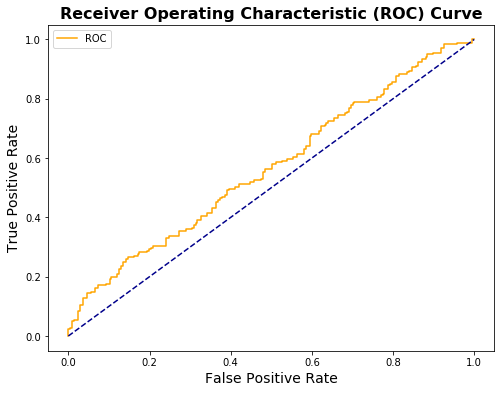

In [437]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [438]:
# Calculate area under ROC curve
search.best_score_

0.5762931843348619

The bigger the area covered (AUC), the better the machine learning model is at distinguishing the given classes. The ideal value for AUC being 1, our model is far from the best-case scenario since it is only 57.6% accurate for instances and their classifications. Our model's AUC is close to 0.5, which is when both the class distributions simply mimic each other (i.e. the model has no discrimination capabilities at all). However, since our AUC is above 0.5, we can say that it does have some discrimination capabilities. In other words, it performs better than chance (50%), albeit slightly.


# Model Interpretation

## Permutation Importance

### with `sklearn`
<br>

Examine variable importance i.e. which variables does the model rely on most when making predictions? 

Permute the features to determine importance. Note here that I only do this 5 times for the sake of runtime, but you'd want to do this more (e.g. 30 times)

In [699]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

Organize the output as a data frame. 

In [700]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals (2 S.D below and above)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view dataframe
vi_dat

variable        vi       std       low      high
0                 v2x_corr  0.033669  0.003524  0.026620  0.040718
1         v2x_EDcomp_thick  0.029390  0.004014  0.021361  0.037419
2               v2x_freexp  0.027685  0.003109  0.021467  0.033902
3            v2xpe_exlecon  0.026174  0.003907  0.018360  0.033989
4              v2xcl_prpty  0.025867  0.004810  0.016247  0.035487
5          v2xpe_exlgender  0.025587  0.003046  0.019495  0.031679
6              v2xcl_acjst  0.025000  0.004241  0.016517  0.033483
7                 v2x_rule  0.023182  0.002710  0.017763  0.028602
8               v2x_gender  0.021812  0.002679  0.016453  0.027171
9              v2xps_party  0.020917  0.003032  0.014853  0.026981
10              v2x_civlib  0.019631  0.002522  0.014586  0.024676
11       v2x_ex_confidence  0.017701  0.004066  0.009569  0.025833
12              v2x_neopat  0.017366  0.003534  0.010298  0.024433
13         v2x_ex_direlect  0.014681  0.004193  0.006295  0.023068
14  v2x_accountability_osp  0.013898  0.003909  0.006080  0.021716
15              v2xcl_disc  0.013367  0.003256  0.006855  0.019879
16              v2xcs_ccsi  0.013367  0.003397  0.006573  0.020161
17            v2xpe_exlgeo  0.012975  0.002968  0.007040  0.018911
18             v2xcl_dmove  0.012556  0.004078  0.004399  0.020712
19            v2x_ex_party  0.011913  0.002416  0.007081  0.016745
20         v2x_ex_military  0.010906  0.002874  0.005159  0.016653
21             v2xcl_slave  0.007131  0.001958  0.003214  0.011048
22          v2xpe_exlsocgr  0.004279  0.002844 -0.001409  0.009966
23            v2xpe_exlpol  0.003775  0.003115 -0.002454  0.010004
24       v2x_ex_hereditary  0.001510  0.000793 -0.000076  0.003096
25                      AS  0.001007  0.000548 -0.000089  0.002103
26                      EU  0.000391  0.001220 -0.002049  0.002832
27                      AF  0.000112  0.000676 -0.001240  0.001463

Visualize

In [701]:
# Plot
plot_ml3_vi = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="Predictors",title="Variable Importance")
)


# save plot
plot_ml3_vi.save("plot_ml3_vi.png", dpi =300)

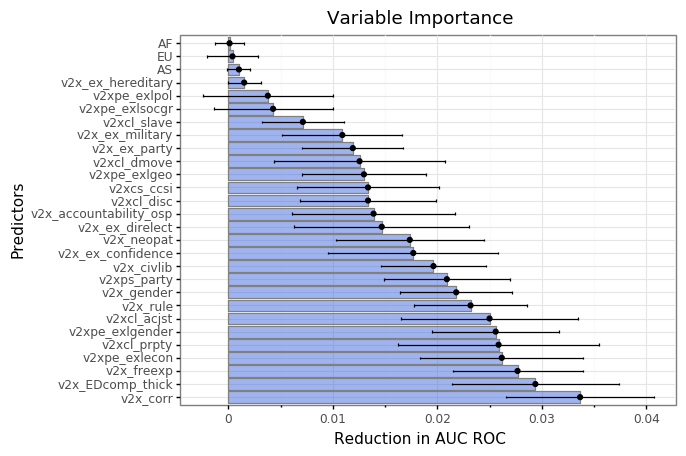

<ggplot: (-9223371940650082564)>

In [702]:
plot_ml3_vi

Among the other indicators, the most important is v2x_corr, followed by v2x_EDcomp_thick and v2x_freexp.

**v2x_corr**: Political corruption index 
<br>
Question: How pervasive is political corruption?
<br>
Clarification: The directionality of the V-Dem corruption index runs from less corrupt to more
corrupt unlike the other V-Dem variables that generally run from less democratic to more
democratic situation. The corruption index includes measures of six distinct types of corruption
that cover both different areas and levels of the polity realm, distinguishing between executive,
legislative and judicial corruption. Within the executive realm, the measures also distinguish
between corruption mostly pertaining to bribery and corruption due to embezzlement. Finally,
they differentiate between corruption in the highest echelons of the executive at the level of
the rulers/cabinet on the one hand, and in the public sector at large on the other. The
measures thus tap into several distinguished types of corruption: both ‘petty’ and ‘grand’;
both bribery and theft; both corruption aimed and influencing law making and that affecting
implementation.

**v2x_freexp**: Freedom of expression index 
<br>
Question: To what extent does government respect press and media freedom, the freedom of
ordinary people to discuss political matters at home and in the public sphere, as well as the
freedom of academic and cultural expression?

**v2x_EDcomp_thick**: Electoral component index 
<br>
Question: To what extent is the electoral principle of democracy achieved?
<br>
Clarification: The electoral principle of democracy seeks to achieve responsiveness and accountability between leaders and citizens through the mechanism of competitive elections. This is
presumed to be achieved when suffrage is extensive; political and civil society organizations
can operate freely; elections are clean and not marred by fraud or systematic irregularities;
and the chief executive of a country is selected directly or indirectly through elections.





## ICE Plots

### with `pdpbox`

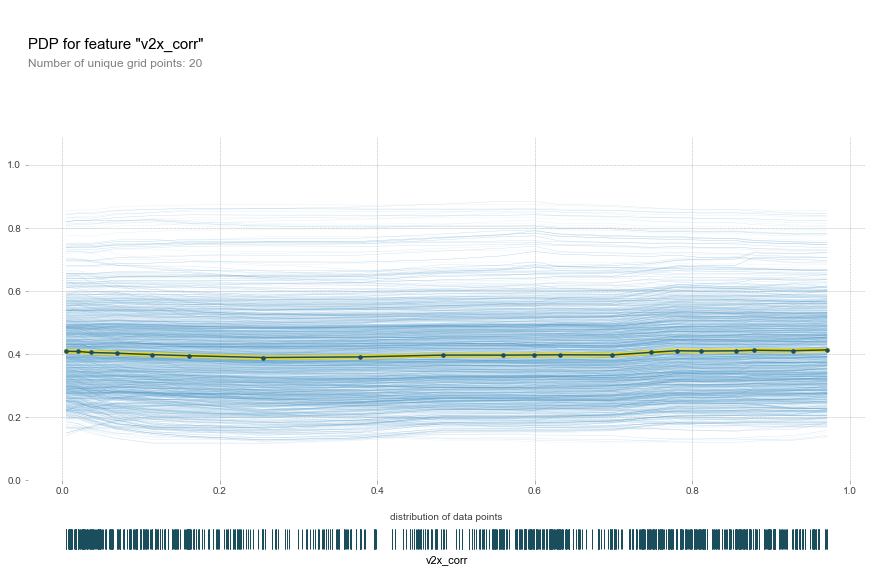

In [703]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="v2x_corr",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'v2x_corr',plot_pts_dist=True,
                      center=False,plot_lines=True, # ICE part                          
                      figsize=(15,10))

**centering** the plot around the baseline (minimum) value of the variable of interest. 

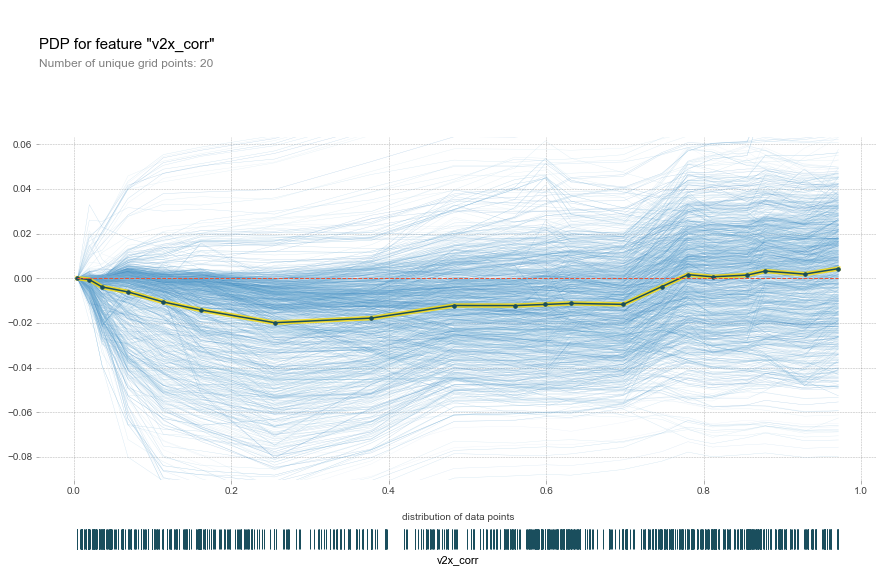

In [704]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="v2x_corr",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'v2x_corr',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

There's evidence here that there is a lot of heterogeneity (or a lot of interaction) in this model since generally the data is not moving in the same flow.  

## Partial Dependency Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

### with `sklearn`

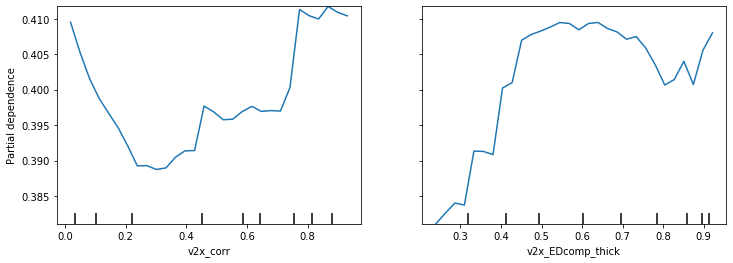

In [705]:
# Target specific features
features = ['v2x_corr','v2x_EDcomp_thick']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

Between 0 and 0.2, as v2x_corr increases, the probability of an increase in educational expenditure decreases. After 0.2 however, an increase in v2x_corr largely results in the likelihood of an increase in educational expenditure. However, it should be noted that the difference between the lowest and highest probabilities is around 2%.

As the level of v2x_EDcomp_thick increases, the probability of an increase in educational expenditre increases. Between levels of v2x_EDcomp_thick of 0.45 and 0.725, there is close to no effect on the likelihood of an increase in educational spending and between 0.725 and 0.8, the probability actually falls.


As the level of v2x_gender increases till 0.2, the probability of an increase in educational spending decreases. After 0.2 however, the effect of v2x_corr becomes largely positive.


Between 0.2 and 0.45, the effect of v2x_EDcomp_thick on the probability of an increase in educational spending is largely positive. Between 0.45 and 0.7, the effect is more or less constant.

#### First fit the partial dependencies. 

In [706]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="v2x_corr")

Then plot them.

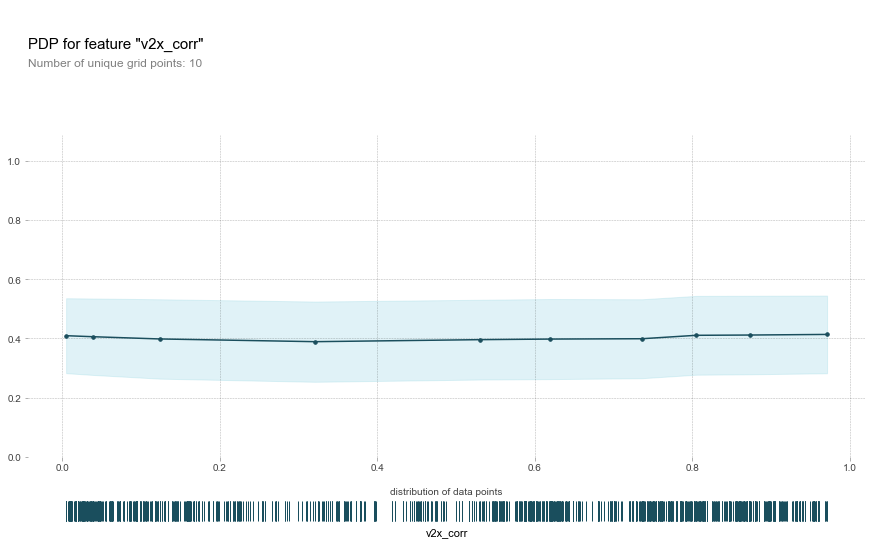

In [707]:
fig,ax = pdp.pdp_plot(pdp_dist,'v2x_corr',plot_pts_dist=True,center=False,)

# light blue = ICE plot

Till about 0.7, an increase in v2x_corr has close to no effect on the probability of an increase in education expenditure. After 0.8, increase in v2x_corr slightly increases the probability of an increase in education expenditure. 

#### Interaction Partial Dependency Plots (2D)
Check interaction between the two most important variables - plot the interactions as a grid (which are more interpretable)

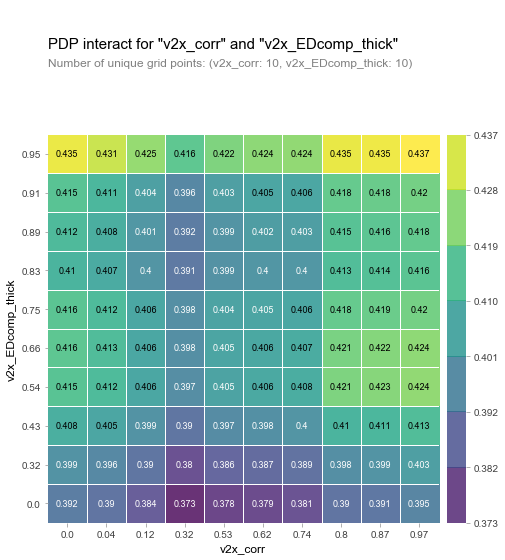

In [708]:
# plotting interaction as a grid 
inter1  =  pdp.pdp_interact(model = rf_mod, 
                            dataset = train_X,
                            model_features = train_X.columns,
                            features=["v2x_corr",'v2x_EDcomp_thick'])

fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                               feature_names=["v2x_corr",'v2x_EDcomp_thick'],
                               plot_type="grid")

This graph shows predictions for any combination of v2x_corr and v2x_EDcomp_thick.
At high levels of v2x_EDcomp_thick, any extremely low or extremely high values of v2x_corr improves the probability of an increase in education expenditure.

## Global Surrogate Models

(1) Generate a vector of predictions (specifically, predicted probabilities since this is a classification problem). 

In [712]:
pr_y = rf_mod.predict_proba(train_X)[:,rf_mod.classes_ == 1]
pr_y

array([[0.46738609],
       [0.32564114],
       [0.48286129],
       ...,
       [0.22146199],
       [0.59696538],
       [0.59049675]])

(2) Fit the surrogate model on the predictions

In [716]:
surrogate_model = DT(max_depth=10) #regression DT
surrogate_model.fit(train_X,pr_y)

DecisionTreeRegressor(max_depth=10)

(3) Examine the model fit ($R^2$)

In [717]:
m.r2_score(pr_y,surrogate_model.predict(train_X)).round(2)

0.76

(4) Plot the tree and interpret

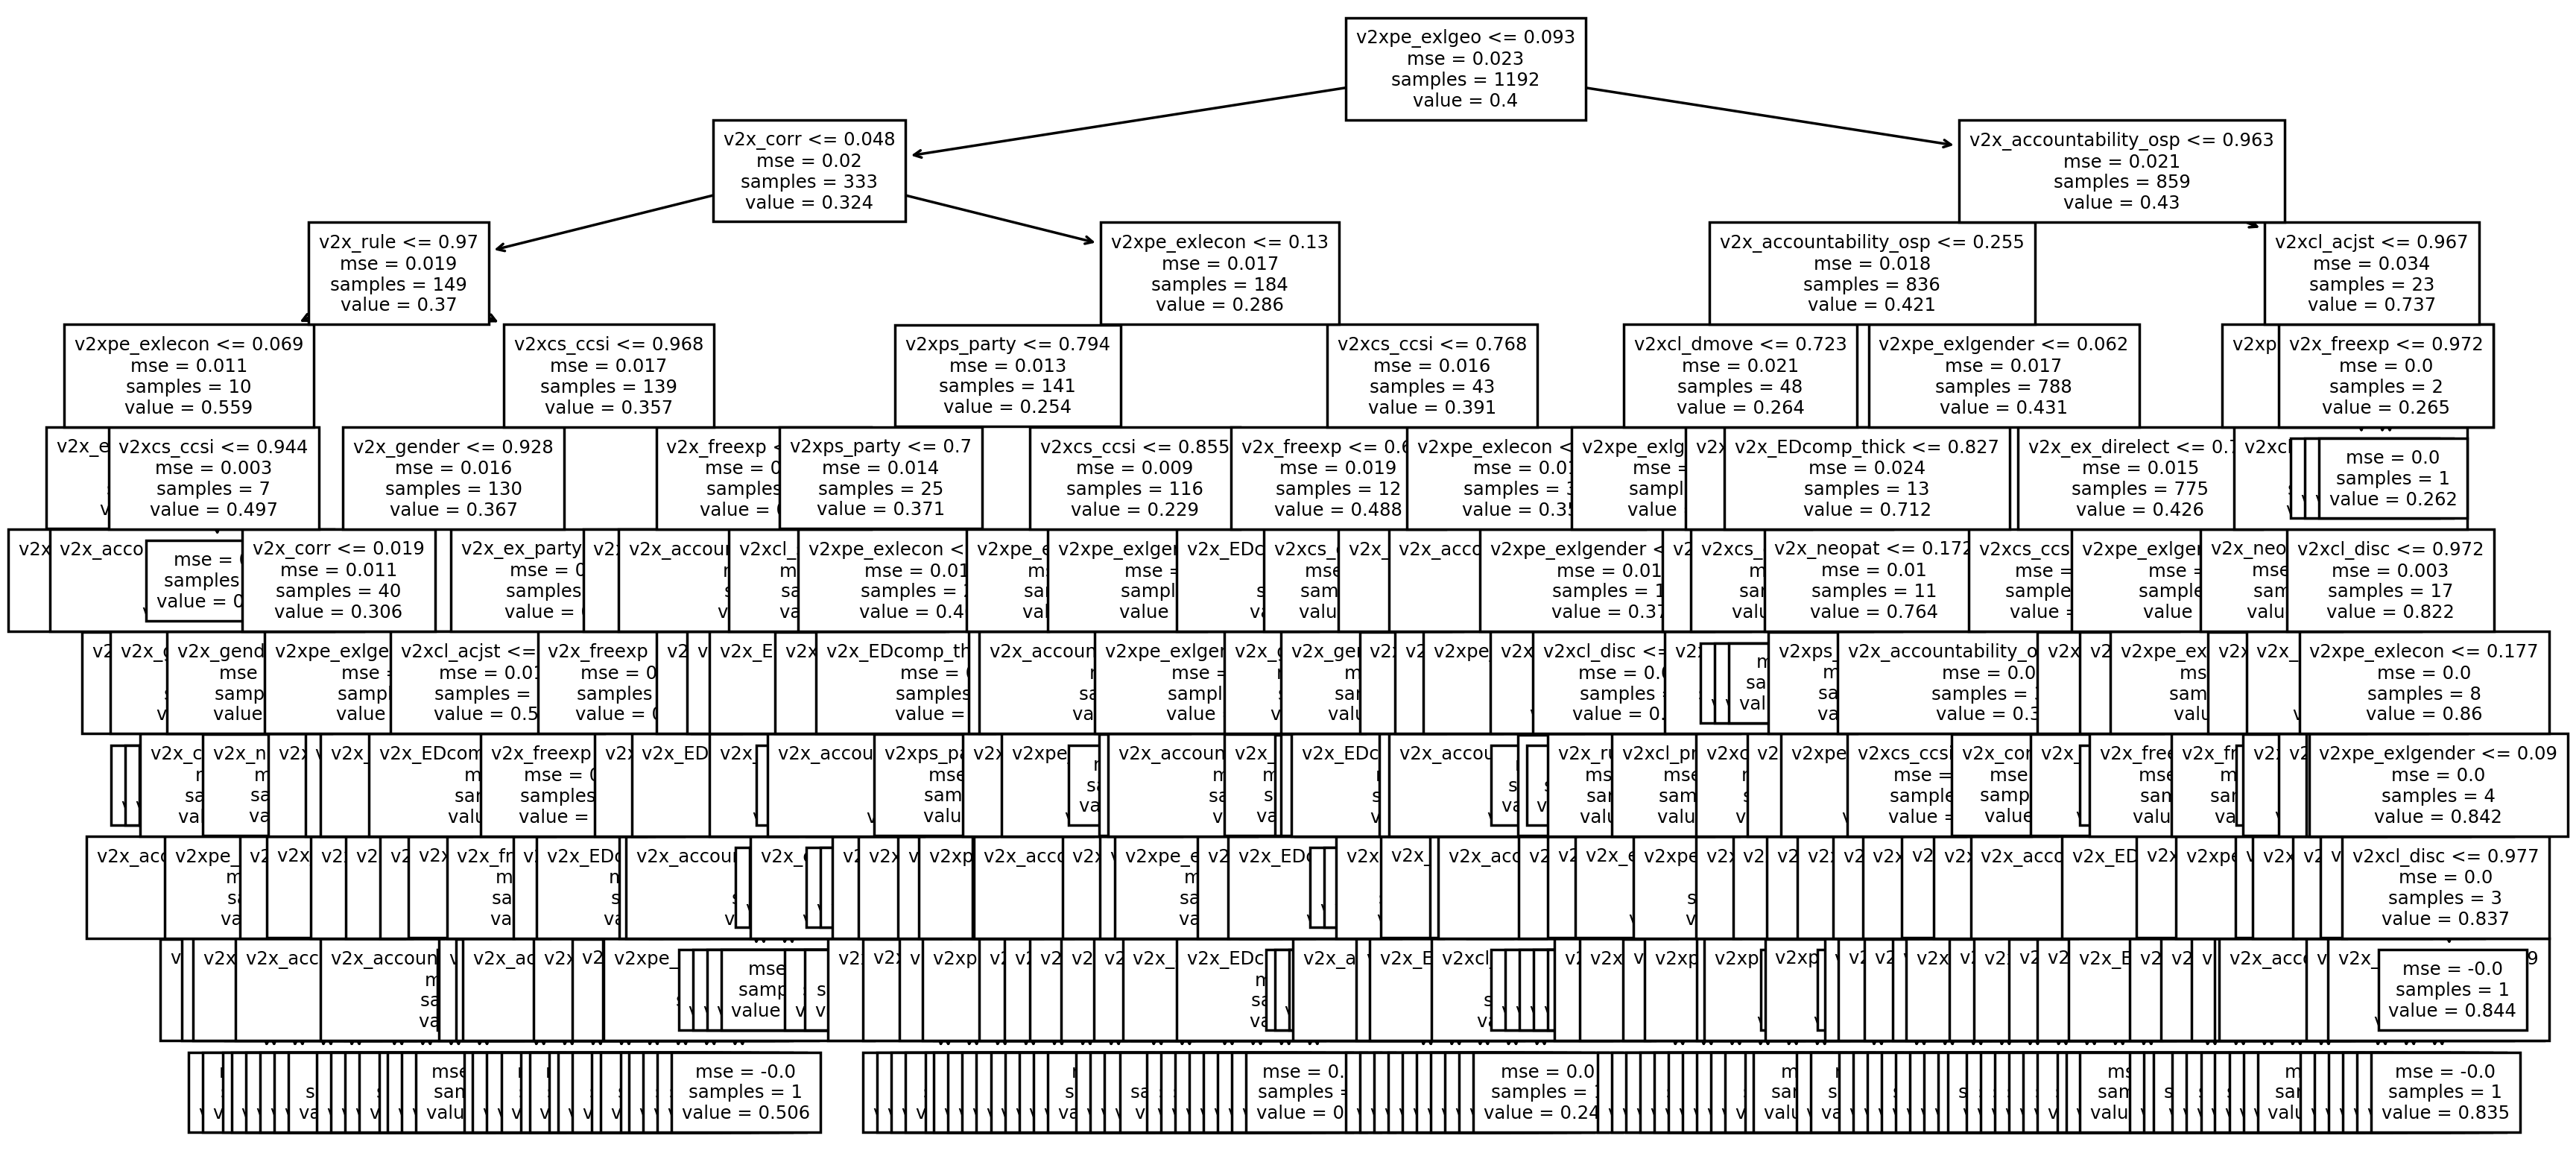

In [718]:
# Plot the tree
plt.figure(figsize=(16,8),dpi=250)
rules = tree.plot_tree(surrogate_model,feature_names=train_X.columns,fontsize=7)